# Projet Knapsack Problem 0-1

**Équipe:** Chaabane, Arman, Bartosz, Ahmed

## Structure du projet

1. Infrastructure commune (Classes et structures de données)
2. Algorithmes implémentés
3. Système de benchmarking complet
4. Analyse comparative approfondie

---
## 1. Configuration et Imports

In [2]:
import time
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from typing import Literal, Optional, Tuple, List
from dataclasses import dataclass
from itertools import combinations
from pathlib import Path
from collections import defaultdict
from types import SimpleNamespace

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

ALGO_COLORS = {
    'Brute Force': '#e41a1c',
    'Dynamic Programming': '#377eb8',
    'DP Top-Down': '#4daf4a',
    'Branch and Bound': '#984ea3',
    'Greedy Ratio': '#ff7f00', 
    'Greedy Value': '#ffff33', 
    'Greedy Weight': '#a65628', 
    'Fractional Knapsack': '#f781bf',
    'Randomized': '#999999', 
    'Genetic Algorithm': '#17becf',  
    'Genetic Adaptive': '#1f77b4',      
    'Simulated Annealing': '#d62728',   
    'SA Adaptive': '#ff9896',          
    'FTPAS (ε=0.1)': '#9467bd',         
    'FTPAS (ε=0.05)': '#8c564b',        
    'FTPAS Adaptive': '#e377c2',        
}

## Générateur de Benchmarks Knapsack

Ce générateur permet de créer des fichiers de benchmark personnalisés avec différents paramètres :
- **Type de corrélation** : uncorrelated, weakly_correlated, strongly_correlated, similar_weights
- **Nombre d'items (n)** : nombre d'objets dans l'instance
- **Plage des poids (R)** : valeur maximale pour les poids générés aléatoirement
- **Capacité** : peut être spécifiée ou calculée automatiquement (généralement 50% de la somme des poids)

In [ ]:
GENERATED_DIR = "benchmarks/generated"

@dataclass
class KnapsackInstance:
    n: int
    capacity: int
    weights: List[int]
    values: List[int]
    correlation_type: str
    
    def __str__(self):
        return f"KnapsackInstance(n={self.n}, capacity={self.capacity}, type={self.correlation_type})"


class KnapsackBenchmarkGenerator:
    CORRELATION_TYPES = [
        'uncorrelated',
        'weakly_correlated', 
        'strongly_correlated'
    ]
    
    def __init__(self):
        self.rng = np.random.default_rng()
    
    def generate(self, n: int, R: int = 1000, capacity: Optional[int] = None,
                 capacity_ratio: float = 0.5, correlation_type: str = 'uncorrelated',
                 correlation_param: float = 100.0) -> KnapsackInstance:
        if correlation_type not in self.CORRELATION_TYPES:
            raise ValueError(f"Type inconnu: {correlation_type}. Choix: {self.CORRELATION_TYPES}")
        
        weights = self._generate_weights(n, R, correlation_type, correlation_param)
        values = self._generate_values(weights, R, correlation_type, correlation_param)
        
        if capacity is None:
            capacity = int(capacity_ratio * sum(weights))
        capacity = max(1, capacity)
        
        return KnapsackInstance(n=n, capacity=capacity, weights=weights.tolist(), 
                                values=values.tolist(), correlation_type=correlation_type)
    
    def _generate_weights(self, n: int, R: int, correlation_type: str, correlation_param: float) -> np.ndarray:
        weights = self.rng.integers(1, R + 1, n)
        return weights.astype(int)
    
    def _generate_values(self, weights: np.ndarray, R: int, correlation_type: str, correlation_param: float) -> np.ndarray:
        n = len(weights)
        if correlation_type == 'uncorrelated':
            values = self.rng.integers(1, R + 1, n)
        elif correlation_type == 'weakly_correlated':
            noise = self.rng.integers(-int(correlation_param), int(correlation_param) + 1, n)
            values = np.maximum(weights + noise, 1)
        elif correlation_type == 'strongly_correlated':
            values = weights + int(correlation_param)
        return values.astype(int)
    
    def _build_filename(self, instance: KnapsackInstance, index: int = None, format: str = 'standard') -> str:
        ext = '.kp' if format == 'kp' else '.txt'
        base = f"{instance.correlation_type}_n{instance.n}_c{instance.capacity}"
        if index is not None:
            return f"{base}_{index:03d}{ext}"
        return f"{base}{ext}"
    
    def save_to_file(self, instance: KnapsackInstance, filepath: str = None,
                     index: int = None, format: Literal['standard', 'kp'] = 'standard') -> str:
        if filepath is None:
            filepath = os.path.join(GENERATED_DIR, self._build_filename(instance, index, format))
        
        os.makedirs(os.path.dirname(filepath) if os.path.dirname(filepath) else '.', exist_ok=True)
        with open(filepath, 'w') as f:
            if format == 'standard':
                f.write(f"{instance.n} {instance.capacity}\n")
                for v, w in zip(instance.values, instance.weights):
                    f.write(f"{v} {w}\n")
            elif format == 'kp':
                f.write(f"\n{instance.n}\n{instance.capacity}\n\n")
                for v, w in zip(instance.values, instance.weights):
                    f.write(f"{v} {w}\n")
        return filepath


def generate_benchmarks(n: int, capacity: int = None, correlation = 'uncorrelated',
                        R: int = 1000, count: int = 1, format: str = 'standard') -> List[KnapsackInstance]:
    """
    Génère un ou plusieurs fichiers de benchmark.
    
    Args:
        n: Nombre d'items
        capacity: Capacité du sac (None = 50% de la somme des poids)
        correlation: Type ou liste de types ('uncorrelated', 'weakly_correlated', 'strongly_correlated')
        R: Poids max [1, R]
        count: Nombre de fichiers à générer par type
        format: 'standard' (.txt) ou 'kp'
    """
    generator = KnapsackBenchmarkGenerator()
    instances = []
    
    correlations = [correlation] if isinstance(correlation, str) else correlation
    
    for corr_type in correlations:
        for i in range(count):
            instance = generator.generate(n=n, R=R, capacity=capacity, correlation_type=corr_type)
            index = i + 1 if count > 1 else None
            filepath = generator.save_to_file(instance, index=index, format=format)
            instances.append(instance)
    
    return instances


print(f"Dossier: {GENERATED_DIR}")
print(f"Types: {KnapsackBenchmarkGenerator.CORRELATION_TYPES}")

Dossier: benchmarks/generated
Types: ['uncorrelated', 'weakly_correlated', 'strongly_correlated', 'similar_weights', 'inverse_strongly_correlated']


### Utilisation du générateur

In [ ]:
# =============================================================================
# GENERATOR OF BENCHMARK
# =============================================================================
# Types: 'uncorrelated', 'weakly_correlated', 'strongly_correlated'
# =============================================================================
generate_benchmarks(n=100, capacity=1000, correlation=['uncorrelated', 'strongly_correlated', 'weakly_correlated'], count=6)
generate_benchmarks(n=200, capacity=1000, correlation=['uncorrelated', 'strongly_correlated', 'weakly_correlated'], count=2)
generate_benchmarks(n=500, capacity=1000, correlation=['uncorrelated', 'strongly_correlated', 'weakly_correlated'], count=5)
generate_benchmarks(n=1000, capacity=1000, correlation=['uncorrelated', 'strongly_correlated', 'weakly_correlated'], count=3)
generate_benchmarks(n=2000, capacity=1000, correlation=['uncorrelated', 'strongly_correlated', 'weakly_correlated'], count=3)
generate_benchmarks(n=5000, capacity=1000, correlation=['uncorrelated', 'strongly_correlated', 'weakly_correlated'], count=2)
generate_benchmarks(n=10000, capacity=1000, correlation=['uncorrelated', 'strongly_correlated', 'weakly_correlated'])







# generate_benchmarks(n=100, capacity=5000, correlation='uncorrelated')
# generate_benchmarks(n=100, capacity=5000, correlation='strongly_correlated', count=5)
# generate_benchmarks(n=100, capacity=5000, correlation=['uncorrelated', 'strongly_correlated', 'weakly_correlated'])
# generate_benchmarks(n=100, capacity=5000, correlation=['uncorrelated', 'strongly_correlated', 'weakly_correlated'], count=5)

✓ benchmarks/generated\uncorrelated_n100_c1000_001.txt
✓ benchmarks/generated\uncorrelated_n100_c1000_002.txt
✓ benchmarks/generated\uncorrelated_n100_c1000_003.txt
✓ benchmarks/generated\strongly_correlated_n100_c1000_001.txt
✓ benchmarks/generated\strongly_correlated_n100_c1000_002.txt
✓ benchmarks/generated\strongly_correlated_n100_c1000_003.txt
✓ benchmarks/generated\weakly_correlated_n100_c1000_001.txt
✓ benchmarks/generated\weakly_correlated_n100_c1000_002.txt
✓ benchmarks/generated\weakly_correlated_n100_c1000_003.txt
✓ benchmarks/generated\uncorrelated_n500_c1000_001.txt
✓ benchmarks/generated\uncorrelated_n500_c1000_002.txt
✓ benchmarks/generated\uncorrelated_n500_c1000_003.txt
✓ benchmarks/generated\strongly_correlated_n500_c1000_001.txt
✓ benchmarks/generated\strongly_correlated_n500_c1000_002.txt
✓ benchmarks/generated\strongly_correlated_n500_c1000_003.txt
✓ benchmarks/generated\weakly_correlated_n500_c1000_001.txt
✓ benchmarks/generated\weakly_correlated_n500_c1000_002.tx

[KnapsackInstance(n=500, capacity=1000, weights=[635, 291, 546, 538, 481, 695, 391, 796, 741, 584, 447, 480, 543, 412, 508, 420, 516, 416, 326, 559, 595, 647, 578, 624, 528, 321, 306, 571, 485, 481, 512, 486, 442, 721, 522, 385, 280, 604, 438, 427, 444, 566, 456, 531, 543, 500, 466, 495, 602, 472, 402, 450, 567, 487, 475, 306, 451, 603, 444, 450, 372, 503, 397, 528, 745, 641, 461, 460, 353, 534, 555, 471, 537, 470, 711, 380, 633, 487, 431, 555, 364, 416, 578, 560, 527, 636, 670, 388, 633, 629, 412, 444, 468, 595, 398, 380, 376, 546, 503, 402, 452, 577, 568, 524, 636, 565, 448, 472, 642, 602, 549, 497, 580, 408, 526, 368, 358, 568, 452, 450, 699, 538, 627, 456, 315, 567, 566, 376, 470, 537, 559, 373, 420, 583, 648, 611, 576, 558, 383, 618, 489, 358, 480, 493, 332, 471, 412, 426, 283, 474, 480, 472, 558, 495, 414, 597, 379, 568, 440, 632, 342, 429, 453, 309, 524, 444, 443, 254, 376, 538, 350, 494, 414, 527, 416, 576, 592, 325, 509, 445, 482, 590, 528, 539, 510, 588, 549, 608, 570, 646, 2

---
## 2. Structures de Données Communes

In [5]:
class Item:
    """Représente un item avec son poids et sa valeur"""
    def __init__(self, item_id, weight, value):
        self.id = item_id
        self.weight = weight
        self.value = value
    
    def ratio(self):
        return self.value / self.weight if self.weight > 0 else 0
    
    def __repr__(self):
        return f"Item({self.id}, w={self.weight}, v={self.value})"


class Problem:
    """Représente une instance du problème de knapsack"""
    def __init__(self, items, capacity):
        self.items = items
        self.capacity = capacity
        self.n = len(items)


class Solution:
    """Représente une solution au problème"""
    def __init__(self, selected_items, total_value, total_weight, time_taken):
        self.selected_items = selected_items
        self.total_value = total_value
        self.total_weight = total_weight
        self.time = time_taken
        self.usage_percent = (total_weight / 1.0) * 100  # Sera mis à jour

### 4.1 Brute Force

In [ ]:
def brute_force(problem):
    """
    Algorithme de force brute pour le problème du sac à dos 0-1
    
    Explore toutes les combinaisons possibles d'items pour trouver
    la solution optimale. Garantit la solution optimale mais avec
    une complexité exponentielle.
    
    Args:
        problem: Instance du problème (Problem object) contenant
                 les items et la capacité du sac
    
    Returns:
        Solution object avec la solution optimale
    
    Note:
        Ne pas utiliser pour n > 20-25 items (temps prohibitif)
    """
    start_time = time.time()
    
    best_value = 0
    best_weight = 0
    best_items = []
    
    for size in range(problem.n + 1):
        for combo in combinations(range(problem.n), size):
            total_weight = sum(problem.items[i].weight for i in combo)
            total_value = sum(problem.items[i].value for i in combo)
            
            if total_weight <= problem.capacity and total_value > best_value:
                best_value = total_value
                best_weight = total_weight
                best_items = list(combo)
    
    time_taken = time.time() - start_time
    sol = Solution(best_items, best_value, best_weight, time_taken)
    sol.usage_percent = (best_weight / problem.capacity) * 100 if problem.capacity > 0 else 0
    return sol

### 4.2 Programmation Dynamique

In [ ]:
def dynamic_programming(problem):
    """
    Programmation dynamique Bottom-Up pour le problème du sac à dos 0-1
    
    Construit une table de mémoïsation de manière itérative en partant
    des sous-problèmes les plus simples vers le problème complet.
    Garantit la solution optimale en temps pseudo-polynomial.
    
    Args:
        problem: Instance du problème (Problem object) contenant
                 les items et la capacité du sac
    
    Returns:
        Solution object avec la solution optimale, ou None si
        la matrice est trop grande (protection mémoire)
    
    Note:
        Limité par la mémoire pour grandes capacités (> 10M cellules)
    """
    start_time = time.time()
    
    n = problem.n
    C = problem.capacity
    
    total_cells = n * C
    if total_cells > 10_000_000:
        print(f"DP Skip: matrice trop grande ({n}×{C:,} = {total_cells:,})")
        return None
    
    estimated_mb = (total_cells * 8) / (1024 * 1024)
    if estimated_mb > 500:
        print(f"DP Skip: mémoire > 500 MB ({estimated_mb:.0f} MB)")
        return None
    
    dp = [[0 for _ in range(C + 1)] for _ in range(n + 1)]
    
    for i in range(1, n + 1):
        item = problem.items[i - 1]
        for w in range(C + 1):
            dp[i][w] = dp[i - 1][w]
            if item.weight <= w:
                dp[i][w] = max(dp[i][w], dp[i - 1][w - item.weight] + item.value)
    
    # Reconstruction
    selected = []
    w = C
    for i in range(n, 0, -1):
        if dp[i][w] != dp[i - 1][w]:
            selected.append(i - 1)
            w -= problem.items[i - 1].weight
    
    total_value = dp[n][C]
    total_weight = sum(problem.items[i].weight for i in selected)
    
    time_taken = time.time() - start_time
    sol = Solution(selected, total_value, total_weight, time_taken)
    sol.usage_percent = (total_weight / problem.capacity) * 100 if problem.capacity > 0 else 0
    return sol

### 4.2.1 Programmation Dynamique Top-Down

In [ ]:
def dynamic_programming_topdown(problem):
    """
    Programmation dynamique Top-Down avec mémoïsation
    
    Avantages par rapport à Bottom-Up:
    - Ne calcule que les sous-problèmes nécessaires
    - Plus intuitif (suit la définition récursive)
    - Peut être plus rapide si tous les sous-problèmes ne sont pas nécessaires
    
    Returns:
        Solution object
    """
    import sys
    start_time = time.time()
    
    n = problem.n
    C = problem.capacity
    items = problem.items
    
    # Protection contre les grandes instances
    total_cells = n * C
    if total_cells > 10_000_000:
        print(f"DP Top-Down Skip: cache trop grand ({n}×{C:,} = {total_cells:,})")
        return None
    
    # Augmenter la limite de récursion si nécessaire
    old_limit = sys.getrecursionlimit()
    if n + 100 > old_limit:
        sys.setrecursionlimit(max(n + 100, old_limit))
    
    # Cache pour mémoïsation: memo[i][w] = valeur max avec items 0..i-1 et capacité w
    memo = {}
    
    def knapsack(i, w):
        """
        Retourne la valeur maximale possible avec les items 0..i-1 et capacité w
        """
        # Cas de base
        if i == 0 or w == 0:
            return 0
        
        # Vérifier le cache
        if (i, w) in memo:
            return memo[(i, w)]
        
        item = items[i - 1]
        
        # Si l'item est trop lourd, on ne peut pas le prendre
        if item.weight > w:
            result = knapsack(i - 1, w)
        else:
            # Max entre prendre et ne pas prendre l'item
            not_take = knapsack(i - 1, w)
            take = knapsack(i - 1, w - item.weight) + item.value
            result = max(not_take, take)
        
        memo[(i, w)] = result
        return result
    
    # Calculer la valeur optimale
    try:
        best_value = knapsack(n, C)
    except RecursionError:
        print(f"DP Top-Down Skip: récursion trop profonde (n={n})")
        sys.setrecursionlimit(old_limit)
        return None
    
    # Reconstruction de la solution
    selected = []
    w = C
    for i in range(n, 0, -1):
        if w == 0:
            break
        item = items[i - 1]
        # Si la valeur change quand on exclut cet item, c'est qu'on l'a pris
        val_with = memo.get((i, w), 0)
        val_without = memo.get((i - 1, w), 0)
        if val_with != val_without:
            selected.append(i - 1)
            w -= item.weight
    
    total_weight = sum(items[i].weight for i in selected)
    
    # Restaurer la limite de récursion
    sys.setrecursionlimit(old_limit)
    
    time_taken = time.time() - start_time
    sol = Solution(selected, best_value, total_weight, time_taken)
    sol.usage_percent = (total_weight / problem.capacity) * 100 if problem.capacity > 0 else 0
    return sol

### 4.3 Branch and Bound

In [ ]:
def branch_and_bound(problem):
    """
    Algorithme Branch and Bound pour le problème du sac à dos 0-1
    
    Explore l'arbre des solutions de manière intelligente en utilisant
    une borne supérieure (relaxation fractionnelle) pour élaguer les
    branches non prometteuses. Garantit la solution optimale.
    
    Stratégie:
    - Tri des items par ratio valeur/poids décroissant
    - Calcul d'une borne supérieure par relaxation fractionnelle
    - Élagage des branches dont la borne < meilleure solution connue
    
    Args:
        problem: Instance du problème (Problem object) contenant
                 les items et la capacité du sac
    
    Returns:
        Solution object avec la solution optimale
    """
    start_time = time.time()
    
    sorted_indices = sorted(range(problem.n), 
                          key=lambda i: problem.items[i].ratio(), 
                          reverse=True)
    
    best_value = 0
    best_solution = []
    
    def bound(level, current_weight, current_value):
        if current_weight >= problem.capacity:
            return 0
        
        value_bound = current_value
        total_weight = current_weight
        
        for i in range(level, problem.n):
            idx = sorted_indices[i]
            item = problem.items[idx]
            
            if total_weight + item.weight <= problem.capacity:
                total_weight += item.weight
                value_bound += item.value
            else:
                remaining = problem.capacity - total_weight
                value_bound += item.value * (remaining / item.weight)
                break
        
        return value_bound
    
    def branch(level, current_weight, current_value, current_items):
        nonlocal best_value, best_solution
        
        if level == problem.n:
            if current_value > best_value:
                best_value = current_value
                best_solution = current_items[:]
            return
        
        idx = sorted_indices[level]
        item = problem.items[idx]
        
        if current_weight + item.weight <= problem.capacity:
            new_value = current_value + item.value
            if bound(level + 1, current_weight + item.weight, new_value) > best_value:
                current_items.append(idx)
                branch(level + 1, current_weight + item.weight, new_value, current_items)
                current_items.pop()
        
        if bound(level + 1, current_weight, current_value) > best_value:
            branch(level + 1, current_weight, current_value, current_items)
    
    branch(0, 0, 0, [])
    
    total_weight = sum(problem.items[i].weight for i in best_solution)
    time_taken = time.time() - start_time
    
    sol = Solution(best_solution, best_value, total_weight, time_taken)
    sol.usage_percent = (total_weight / problem.capacity) * 100 if problem.capacity > 0 else 0
    return sol

### 4.4 Algorithmes Gloutons

In [ ]:
def greedy_by_value(problem):
    """
    Algorithme glouton par valeur décroissante
    
    Sélectionne les items par ordre de valeur décroissante
    tant que la capacité le permet. Simple mais non optimal.
    
    Args:
        problem: Instance du problème (Problem object) contenant
                 les items et la capacité du sac
    
    Returns:
        Solution object (potentiellement sous-optimale)
    
    Note:
        Favorise les items de grande valeur, peut ignorer
        des combinaisons plus rentables d'items moins chers
    """
    start_time = time.time()
    
    sorted_items = sorted(enumerate(problem.items), key=lambda x: x[1].value, reverse=True)
    
    selected = []
    total_weight = 0
    total_value = 0
    
    for idx, item in sorted_items:
        if total_weight + item.weight <= problem.capacity:
            selected.append(idx)
            total_weight += item.weight
            total_value += item.value
    
    time_taken = time.time() - start_time
    sol = Solution(selected, total_value, total_weight, time_taken)
    sol.usage_percent = (total_weight / problem.capacity) * 100 if problem.capacity > 0 else 0
    return sol


def greedy_by_weight(problem):
    """
    Algorithme glouton par poids croissant
    
    Sélectionne les items par ordre de poids croissant
    tant que la capacité le permet. Maximise le nombre d'items.
    
    Args:
        problem: Instance du problème (Problem object) contenant
                 les items et la capacité du sac
    
    Returns:
        Solution object (potentiellement sous-optimale)
    
    Note:
        Favorise les petits items, peut ignorer des items
        lourds mais très précieux
    """
    start_time = time.time()
    
    sorted_items = sorted(enumerate(problem.items), key=lambda x: x[1].weight)
    
    selected = []
    total_weight = 0
    total_value = 0
    
    for idx, item in sorted_items:
        if total_weight + item.weight <= problem.capacity:
            selected.append(idx)
            total_weight += item.weight
            total_value += item.value
    
    time_taken = time.time() - start_time
    sol = Solution(selected, total_value, total_weight, time_taken)
    sol.usage_percent = (total_weight / problem.capacity) * 100 if problem.capacity > 0 else 0
    return sol


def greedy_by_ratio(problem):
    """
    Algorithme glouton par ratio valeur/poids décroissant
    
    Sélectionne les items par ordre de densité (valeur/poids)
    décroissante. La meilleure heuristique gloutonne pour le 0-1.
    
    Complexité temporelle: O(n log n) pour le tri
    Complexité spatiale: O(n)
    
    Args:
        problem: Instance du problème (Problem object) contenant
                 les items et la capacité du sac
    
    Returns:
        Solution object (potentiellement sous-optimale mais 
        souvent proche de l'optimal)
    
    Note:
        Stratégie optimale pour le knapsack fractionnel,
        bonne heuristique pour le 0-1
    """
    start_time = time.time()
    
    sorted_items = sorted(enumerate(problem.items), key=lambda x: x[1].ratio(), reverse=True)
    
    selected = []
    total_weight = 0
    total_value = 0
    
    for idx, item in sorted_items:
        if total_weight + item.weight <= problem.capacity:
            selected.append(idx)
            total_weight += item.weight
            total_value += item.value
    
    time_taken = time.time() - start_time
    sol = Solution(selected, total_value, total_weight, time_taken)
    sol.usage_percent = (total_weight / problem.capacity) * 100 if problem.capacity > 0 else 0
    return sol

### 4.4.1 Fractional Knapsack (Sac à dos fractionnel)

In [ ]:
def fractional_knapsack(problem):
    """
    Fractional Knapsack - Algorithme glouton optimal pour le sac à dos fractionnel
    
    Différence avec 0-1 Knapsack:
    - Permet de prendre une FRACTION d'un item
    - Solution optimale garantie (contrairement au 0-1)
    - Sert de borne supérieure pour le 0-1 Knapsack
    
    Stratégie: Trier par ratio valeur/poids décroissant et prendre 
    les items dans cet ordre (fractions si nécessaire)
    
    Returns:
        Solution object avec fraction_taken indiquant les fractions prises
    """
    start_time = time.time()
    
    n = problem.n
    capacity = problem.capacity
    items = problem.items
    
    # Trier les items par ratio valeur/poids décroissant
    sorted_items = sorted(enumerate(items), key=lambda x: x[1].ratio(), reverse=True)
    
    total_value = 0.0
    total_weight = 0.0
    selected = []  # Liste de tuples (index, fraction_prise)
    fractions = {}  # Pour stocker les fractions de chaque item
    
    remaining_capacity = capacity
    
    for idx, item in sorted_items:
        if remaining_capacity <= 0:
            break
            
        if item.weight <= remaining_capacity:
            # Prendre l'item entier
            selected.append(idx)
            fractions[idx] = 1.0
            total_value += item.value
            total_weight += item.weight
            remaining_capacity -= item.weight
        else:
            # Prendre une fraction de l'item
            fraction = remaining_capacity / item.weight
            fractions[idx] = fraction
            total_value += item.value * fraction
            total_weight += item.weight * fraction
            selected.append(idx)
            remaining_capacity = 0
    
    time_taken = time.time() - start_time
    
    # Créer la solution
    # Note: total_value peut être un float, on le garde ainsi pour la précision
    sol = Solution(selected, total_value, total_weight, time_taken)
    sol.usage_percent = (total_weight / capacity) * 100 if capacity > 0 else 0
    sol.fractions = fractions  # Stocker les fractions pour référence
    sol.is_fractional = True  # Marquer comme solution fractionnelle
    
    return sol


def fractional_knapsack_bound(problem):
    """
    Calcule la borne supérieure du problème 0-1 via relaxation fractionnelle
    
    Résout le problème du sac à dos fractionnel pour obtenir une borne
    supérieure sur la valeur optimale du problème 0-1. Utilisé comme
    fonction de bornage dans Branch and Bound.
    
    Args:
        problem: Instance du problème (Problem object) contenant
                 les items et la capacité du sac
    
    Returns:
        float: Valeur maximale possible (borne supérieure pour 0-1)
    
    Note:
        Cette valeur est toujours ≥ à l'optimum du 0-1 Knapsack
    """
    sorted_items = sorted(problem.items, key=lambda x: x.ratio(), reverse=True)
    
    total_value = 0.0
    remaining_capacity = problem.capacity
    
    for item in sorted_items:
        if remaining_capacity <= 0:
            break
        if item.weight <= remaining_capacity:
            total_value += item.value
            remaining_capacity -= item.weight
        else:
            total_value += item.value * (remaining_capacity / item.weight)
            break
    
    return total_value

### 4.5 Randomized

In [ ]:
def randomized_approach(problem, iterations=1000, seed=None):
    """
    Approche randomisée multi-start pour le problème du sac à dos 0-1
    
    Génère plusieurs solutions aléatoires en mélangeant l'ordre des items
    et en les ajoutant goulûment. Conserve la meilleure solution trouvée.
    
    Stratégie:
    - À chaque itération, mélanger aléatoirement les items
    - Construire une solution gloutonne avec cet ordre
    - Garder la meilleure solution parmi toutes les itérations
    
    Args:
        problem: Instance du problème (Problem object) contenant
                 les items et la capacité du sac
        iterations: Nombre de solutions aléatoires à générer (défaut: 1000)
        seed: Graine aléatoire pour reproductibilité (optionnel)
    
    Returns:
        Solution object (qualité dépend du nombre d'itérations)
    
    Note:
        Simple à implémenter, bonne pour exploration rapide,
        mais sans garantie de qualité
    """
    start_time = time.time()
    
    if seed is not None:
        random.seed(seed)
    
    best_value = 0
    best_weight = 0
    best_items = []
    
    for _ in range(iterations):
        indices = list(range(problem.n))
        random.shuffle(indices)
        
        selected = []
        total_weight = 0
        total_value = 0
        
        for idx in indices:
            item = problem.items[idx]
            if total_weight + item.weight <= problem.capacity:
                selected.append(idx)
                total_weight += item.weight
                total_value += item.value
        
        if total_value > best_value:
            best_value = total_value
            best_weight = total_weight
            best_items = selected
    
    time_taken = time.time() - start_time
    sol = Solution(best_items, best_value, best_weight, time_taken)
    sol.usage_percent = (best_weight / problem.capacity) * 100 if problem.capacity > 0 else 0
    return sol

### 4.6 Algorithme Génétique (Genetic Algorithm)

In [ ]:
def genetic_algorithm(problem, population_size=100, generations=50, 
                     crossover_rate=0.8, mutation_rate=0.02, 
                     elitism_count=5, seed=None):
    """
    Algorithme Génétique pour le problème du sac à dos 0-1
    
    Métaheuristique inspirée de l'évolution naturelle. Maintient une
    population de solutions qui évoluent par sélection, croisement
    et mutation sur plusieurs générations.
    
    Opérateurs génétiques:
    - Sélection par tournoi (pression sélective contrôlée)
    - Croisement à deux points (exploration de l'espace)
    - Mutation par flip de bits (diversification)
    - Élitisme (préservation des meilleures solutions)

    Args:
        problem: Instance du problème (Problem object)
        population_size: Taille de la population (nombre de chromosomes)
        generations: Nombre de générations (itérations)
        crossover_rate: Probabilité de croisement (0.0 à 1.0)
        mutation_rate: Probabilité de mutation par gène (0.0 à 1.0)
        elitism_count: Nombre de meilleures solutions à conserver
        seed: Graine aléatoire pour reproductibilité
    
    Returns:
        Solution object (bonne qualité sans garantie d'optimalité)
    """
    start_time = time.time()
    
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
    
    n = problem.n
    capacity = problem.capacity
    items = problem.items
    
    # === 1. FONCTION DE FITNESS ===
    def fitness(chromosome):
        """Qualité d'un chromosome (solution)"""
        total_weight = sum(chromosome[i] * items[i].weight for i in range(n))
        total_value = sum(chromosome[i] * items[i].value for i in range(n))
        
        # Pénalité si capacité dépassée
        if total_weight > capacity:
            # Pénalité proportionnelle au dépassement
            penalty = (total_weight - capacity) * 10
            return max(0, total_value - penalty)
        return total_value
    
    # POPULATION INITIALE
    def create_initial_population():
        """Crée la population initiale avec différentes stratégies"""
        population = []
        
        # 50% solutions aléatoires
        for _ in range(population_size // 2):
            chromosome = [random.randint(0, 1) for _ in range(n)]
            population.append(chromosome)
        
        # 25% solutions greedy (ratio)
        sorted_indices = sorted(range(n), key=lambda i: items[i].ratio(), reverse=True)
        for _ in range(population_size // 4):
            chromosome = [0] * n
            weight = 0
            for idx in sorted_indices:
                if weight + items[idx].weight <= capacity and random.random() > 0.3:
                    chromosome[idx] = 1
                    weight += items[idx].weight
            population.append(chromosome)
        
        # 25% solutions avec densité variable
        for _ in range(population_size - len(population)):
            chromosome = [0] * n
            density = random.uniform(0.2, 0.8)
            weight = 0
            for i in range(n):
                if random.random() < density and weight + items[i].weight <= capacity:
                    chromosome[i] = 1
                    weight += items[i].weight
            population.append(chromosome)
        
        return population
    
    # SÉLECTION PAR TOURNOI
    def tournament_selection(population, fitnesses, tournament_size=3):
        """Sélectionne un individu par tournoi"""
        tournament_indices = random.sample(range(len(population)), tournament_size)
        tournament_fitnesses = [fitnesses[i] for i in tournament_indices]
        winner_idx = tournament_indices[tournament_fitnesses.index(max(tournament_fitnesses))]
        return population[winner_idx]
    
    # CROISEMENT (CROSSOVER)
    def crossover(parent1, parent2):
        """Croisement à deux points"""
        if random.random() > crossover_rate:
            return parent1[:], parent2[:]
        
        # Deux points de coupure
        point1 = random.randint(1, n - 2)
        point2 = random.randint(point1 + 1, n - 1)
        
        child1 = parent1[:point1] + parent2[point1:point2] + parent1[point2:]
        child2 = parent2[:point1] + parent1[point1:point2] + parent2[point2:]
        
        return child1, child2
    
    # MUTATION
    def mutate(chromosome):
        """Mutation par flip de bits"""
        mutated = chromosome[:]
        for i in range(n):
            if random.random() < mutation_rate:
                mutated[i] = 1 - mutated[i]  # Flip 0->1 ou 1->0
        return mutated
    
    # ALGORITHME PRINCIPAL
    population = create_initial_population()
    best_chromosome = None
    best_fitness = -1
    
    for gen in range(generations):
        # Évaluation de la population
        fitnesses = [fitness(chromo) for chromo in population]
        
        # Mise à jour de la meilleure solution
        gen_best_idx = fitnesses.index(max(fitnesses))
        gen_best_fitness = fitnesses[gen_best_idx]
        
        if gen_best_fitness > best_fitness:
            best_fitness = gen_best_fitness
            best_chromosome = population[gen_best_idx][:]
        
        # Tri par fitness (pour l'élitisme)
        sorted_indices = sorted(range(len(population)), key=lambda i: fitnesses[i], reverse=True)
        
        # Nouvelle génération
        new_population = []
        
        # Élitisme : garder les meilleurs
        for i in range(elitism_count):
            new_population.append(population[sorted_indices[i]][:])
        
        # Génération du reste de la population
        while len(new_population) < population_size:
            # Sélection
            parent1 = tournament_selection(population, fitnesses)
            parent2 = tournament_selection(population, fitnesses)
            
            # Croisement
            child1, child2 = crossover(parent1, parent2)
            
            # Mutation
            child1 = mutate(child1)
            child2 = mutate(child2)
            
            new_population.append(child1)
            if len(new_population) < population_size:
                new_population.append(child2)
        
        population = new_population
    
    # MEILLEURE SOLUTION
    selected_items = [i for i in range(n) if best_chromosome[i] == 1]
    total_value = sum(items[i].value for i in selected_items)
    total_weight = sum(items[i].weight for i in selected_items)
    
    time_taken = time.time() - start_time
    
    sol = Solution(selected_items, total_value, total_weight, time_taken)
    sol.usage_percent = (total_weight / capacity * 100) if capacity > 0 else 0
    
    return sol


def genetic_algorithm_adaptive(problem):
    """
    Version adaptative de l'algorithme génétique
    
    Ajuste automatiquement les paramètres (taille de population,
    nombre de générations, taux de mutation) selon la taille
    du problème pour un bon compromis qualité/temps.
    
    Args:
        problem: Instance du problème (Problem object) contenant
                 les items et la capacité du sac
    
    Returns:
        Solution object
    
    Note:
        - Petites instances (n≤50): exploration plus fine
        - Grandes instances (n>1000): convergence plus rapide
    """
    n = problem.n
    
    if n <= 50:
        return genetic_algorithm(problem, population_size=50, generations=30, mutation_rate=0.03)
    elif n <= 100:
        return genetic_algorithm(problem, population_size=80, generations=40, mutation_rate=0.02)
    elif n <= 500:
        return genetic_algorithm(problem, population_size=100, generations=50, mutation_rate=0.02)
    elif n <= 1000:
        return genetic_algorithm(problem, population_size=120, generations=40, mutation_rate=0.01)
    else:
        return genetic_algorithm(problem, population_size=150, generations=30, mutation_rate=0.01)

### 4.6.1 Simulated Annealing (Recuit Simulé)

**Principe:** Inspiré du recuit métallurgique, l'algorithme explore l'espace des solutions en acceptant parfois des solutions moins bonnes pour échapper aux optima locaux. La probabilité d'accepter une mauvaise solution diminue avec la "température".

In [ ]:
def simulated_annealing(problem, initial_temp=1000, cooling_rate=0.995, 
                        min_temp=1, max_iterations=10000, seed=None):
    """
    Simulated Annealing (Recuit Simulé) pour le Knapsack 0-1
    
    Principe:
    - Commence avec une solution initiale (greedy)
    - À chaque itération, génère un voisin en flippant un bit
    - Accepte toujours les améliorations
    - Accepte les dégradations avec probabilité exp(-ΔE/T)
    - La température T diminue progressivement (refroidissement)
    
    Args:
        problem: Instance du problème
        initial_temp: Température initiale (contrôle l'exploration)
        cooling_rate: Taux de refroidissement (0.9 à 0.999)
        min_temp: Température minimale (critère d'arrêt)
        max_iterations: Nombre maximum d'itérations
        seed: Graine aléatoire pour reproductibilité
    
    Returns:
        Solution object
    """
    start_time = time.time()
    
    if seed is not None:
        random.seed(seed)
    
    n = problem.n
    capacity = problem.capacity
    items = problem.items
    
    # === FONCTION D'ÉVALUATION ===
    def evaluate(solution):
        """Calcule valeur et poids d'une solution (liste de 0/1)"""
        total_value = sum(solution[i] * items[i].value for i in range(n))
        total_weight = sum(solution[i] * items[i].weight for i in range(n))
        return total_value, total_weight
    
    def fitness(solution):
        """Fitness avec pénalité si capacité dépassée"""
        value, weight = evaluate(solution)
        if weight > capacity:
            # Pénalité proportionnelle au dépassement
            return value - (weight - capacity) * 10
        return value
    
    # === SOLUTION INITIALE (Greedy par ratio) ===
    current_solution = [0] * n
    sorted_indices = sorted(range(n), key=lambda i: items[i].ratio(), reverse=True)
    current_weight = 0
    for idx in sorted_indices:
        if current_weight + items[idx].weight <= capacity:
            current_solution[idx] = 1
            current_weight += items[idx].weight
    
    current_fitness = fitness(current_solution)
    best_solution = current_solution[:]
    best_fitness = current_fitness
    
    # === BOUCLE PRINCIPALE ===
    temperature = initial_temp
    iteration = 0
    
    while temperature > min_temp and iteration < max_iterations:
        # Générer un voisin en flippant un bit aléatoire
        neighbor = current_solution[:]
        flip_idx = random.randint(0, n - 1)
        neighbor[flip_idx] = 1 - neighbor[flip_idx]
        
        neighbor_fitness = fitness(neighbor)
        
        # Calculer la différence d'énergie
        delta = neighbor_fitness - current_fitness
        
        # Décision d'acceptation
        if delta > 0:
            # Amélioration : toujours accepter
            current_solution = neighbor
            current_fitness = neighbor_fitness
        else:
            # Dégradation : accepter avec probabilité exp(delta/T)
            acceptance_prob = math.exp(delta / temperature)
            if random.random() < acceptance_prob:
                current_solution = neighbor
                current_fitness = neighbor_fitness
        
        # Mettre à jour la meilleure solution
        if current_fitness > best_fitness:
            # Vérifier que la solution est valide
            _, weight = evaluate(current_solution)
            if weight <= capacity:
                best_solution = current_solution[:]
                best_fitness = current_fitness
        
        # Refroidissement
        temperature *= cooling_rate
        iteration += 1
    
    # === RÉSULTAT FINAL ===
    # S'assurer que la meilleure solution est valide
    selected_items = [i for i in range(n) if best_solution[i] == 1]
    total_value = sum(items[i].value for i in selected_items)
    total_weight = sum(items[i].weight for i in selected_items)
    
    # Réparer si nécessaire (retirer des items si surpoids)
    if total_weight > capacity:
        # Trier par ratio croissant et retirer
        selected_sorted = sorted(selected_items, key=lambda i: items[i].ratio())
        while total_weight > capacity and selected_sorted:
            remove_idx = selected_sorted.pop(0)
            total_weight -= items[remove_idx].weight
            total_value -= items[remove_idx].value
            selected_items.remove(remove_idx)
    
    time_taken = time.time() - start_time
    
    sol = Solution(selected_items, total_value, total_weight, time_taken)
    sol.usage_percent = (total_weight / capacity * 100) if capacity > 0 else 0
    sol.iterations = iteration
    sol.final_temperature = temperature
    
    return sol


def simulated_annealing_adaptive(problem):
    """
    Version adaptative de Simulated Annealing
    
    Ajuste automatiquement les paramètres (température initiale,
    taux de refroidissement, nombre d'itérations) selon la taille
    du problème pour un bon compromis qualité/temps.
    
    Complexité temporelle: O(max_iterations × n)
    Complexité spatiale: O(n)
    
    Args:
        problem: Instance du problème (Problem object) contenant
                 les items et la capacité du sac
    
    Returns:
        Solution object
    
    Note:
        - Petites instances: refroidissement rapide, exploration fine
        - Grandes instances: refroidissement lent, plus d'itérations
    """
    n = problem.n
    
    if n <= 50:
        return simulated_annealing(problem, initial_temp=500, cooling_rate=0.99, max_iterations=5000)
    elif n <= 200:
        return simulated_annealing(problem, initial_temp=1000, cooling_rate=0.995, max_iterations=10000)
    elif n <= 1000:
        return simulated_annealing(problem, initial_temp=2000, cooling_rate=0.997, max_iterations=15000)
    else:
        return simulated_annealing(problem, initial_temp=5000, cooling_rate=0.999, max_iterations=20000)

### 4.7 FTPAS

In [ ]:
def fptas(problem, epsilon=0.1):
    """
    FPTAS (Fully Polynomial-Time Approximation Scheme) pour le problème du sac à dos.
    
    Garantie: Retourne une solution de valeur ≥ (1-ε) × OPT
    
    L'idée: On scale les valeurs pour réduire la taille du problème DP,
    puis on résout le problème réduit de façon exacte.
    
    Args:
        problem: Instance du problème (Problem object)
        epsilon: Paramètre d'approximation (0 < ε < 1)
                Plus ε est petit, meilleure est l'approximation (mais plus lent)
    
    Returns:
        Solution object
    """
    start_time = time.time()
    
    n = problem.n
    items = problem.items
    capacity = problem.capacity
    
    if epsilon <= 0 or epsilon >= 1:
        print(f"FPTAS: epsilon doit être dans ]0,1[, reçu {epsilon}")
        return None
    
    if n == 0:
        return SimpleNamespace(
            selected_items=[],
            total_value=0,
            total_weight=0,
            time=time.time() - start_time,
            usage_percent=0,
            epsilon=epsilon,
            scaling_factor=0
        )
    
    v_max = max(item.value for item in items)
    
    # Facteur de scaling: K = (ε × v_max) / n
    # Cela garantit que la somme des valeurs scalées est ≤ n²/ε
    K = (epsilon * v_max) / n
    
    # Si K trop petit, on garde les valeurs originales
    if K < 1e-10:
        K = 1e-10
    
    # Créer les valeurs scalées (arrondi inférieur)
    # On stocke aussi l'index original dans la liste items
    scaled_items = []
    for idx, item in enumerate(items):
        scaled_value = int(item.value / K)  # Arrondi inférieur
        scaled_items.append({
            'idx': idx,  # Index dans la liste items
            'weight': item.weight,
            'value': item.value,
            'scaled_value': scaled_value
        })
    
    # Somme maximale des valeurs scalées
    V_scaled = sum(si['scaled_value'] for si in scaled_items)
    
    # Protection mémoire
    if V_scaled > 1_000_000:
        print(f"FPTAS Skip: V_scaled trop grand ({V_scaled:,})")
        return None
    
    estimated_mb = (n * V_scaled * 8) / (1024 * 1024)
    if estimated_mb > 200:  # Max 200 MB
        print(f"FPTAS Skip: mémoire estimée trop grande ({estimated_mb:.0f} MB)")
        return None
    
    V_scaled = int(V_scaled)
    
    # DP sur les valeurs scalées
    # dp[v] = poids minimum pour obtenir exactement la valeur scalée v
    # On utilise une version 1D optimisée en espace
    INF = float('inf')
    dp = [INF] * (V_scaled + 1)
    dp[0] = 0
    
    # parent[v] = (valeur_précédente, idx_item) pour reconstruire la solution
    parent = [None] * (V_scaled + 1)
    
    for idx, si in enumerate(scaled_items):
        sv = si['scaled_value']
        w = si['weight']
        
        # Parcours inverse pour éviter de réutiliser le même item
        for v in range(V_scaled, sv - 1, -1):
            prev_v = v - sv
            if dp[prev_v] != INF:
                new_weight = dp[prev_v] + w
                if new_weight <= capacity and new_weight < dp[v]:
                    dp[v] = new_weight
                    parent[v] = (prev_v, idx)
    
    # Trouver la meilleure valeur scalée atteignable
    best_scaled_value = 0
    for v in range(V_scaled + 1):
        if dp[v] <= capacity:
            best_scaled_value = v
    
    # Reconstruction de la solution
    selected_indices = []
    v = best_scaled_value
    while v > 0 and parent[v] is not None:
        prev_v, idx = parent[v]
        # idx est l'index dans scaled_items, on récupère l'index original de l'item
        original_idx = scaled_items[idx]['idx']
        selected_indices.append(original_idx)
        v = prev_v
    
    # Calculer la valeur et poids réels (selected_indices contient maintenant les indices originaux)
    total_value = sum(items[idx].value for idx in selected_indices)
    total_weight = sum(items[idx].weight for idx in selected_indices)
    
    time_taken = time.time() - start_time
    
    sol = SimpleNamespace(
        selected_items=selected_indices,
        total_value=total_value,
        total_weight=total_weight,
        time=time_taken,
        usage_percent=(total_weight / capacity * 100) if capacity > 0 else 0,
        epsilon=epsilon,
        scaling_factor=K
    )
    
    return sol

# Alias pour compatibilité avec l'ancien nom
ftpas = fptas


def fptas_adaptive(problem, time_budget=None):
    """
    FPTAS adaptatif: ajuste epsilon selon la taille du problème.
    
    Pour les petits problèmes, on utilise un epsilon petit (meilleure qualité).
    Pour les grands problèmes, on augmente epsilon (plus rapide).
    
    Args:
        problem: Instance du problème
        time_budget: Budget de temps optionnel (non utilisé pour l'instant)
    
    Returns:
        Solution object
    """
    n = problem.n
    
    if n <= 50:
        epsilon = 0.05  # Très précis pour petites instances
    elif n <= 100:
        epsilon = 0.1
    elif n <= 500:
        epsilon = 0.2
    else:
        epsilon = 0.3  # Plus rapide pour grandes instances
    
    return fptas(problem, epsilon)

# Alias pour compatibilité
ftpas_adaptive = fptas_adaptive

---
## 5. Système de Benchmarking

### 5.1 Configuration des Tests

In [16]:
MAX_N_CORRELATED = 1000 

INCLUDE_GENERATED = True   # Inclure les benchmarks générés (benchmarks/generated/)


def discover_benchmarks(base_path='benchmarks', max_n_correlated=None):
    """
    Découvre automatiquement tous les fichiers benchmark disponibles.
    Inclut: low_dimension, large_scale, generated
    
    Args:
        base_path: Chemin vers le dossier benchmarks
        max_n_correlated: Taille max pour les benchmarks corrélés (None = utilise MAX_N_CORRELATED)
    
    Returns:
        dict: Structure contenant les benchmarks organisés par catégorie
    """
    if max_n_correlated is None:
        max_n_correlated = MAX_N_CORRELATED
        
    base = Path(base_path)
    
    if not base.exists():
        print(f"Dossier '{base_path}' non trouvé")
        return None
    
    structure = {
        'base_path': str(base),
        'benchmarks': {}
    }
    
    # Scanner low_dimension et large_scale - SANS limite de taille
    simple_categories = ['low_dimension', 'large_scale']
    
    for category in simple_categories:
        category_path = base / category
        if not category_path.exists():
            continue
            
        for file_path in category_path.glob('*.txt'):
            filename = file_path.name
            
            if category == 'low_dimension':
                parts = filename.replace('.txt', '').split('_')
                try:
                    n = int(parts[3])
                    cap = int(parts[4])
                except (IndexError, ValueError):
                    continue
            else:
                parts = filename.replace('.txt', '').split('_')
                try:
                    n = int(parts[2])
                    cap = int(parts[3])
                except (IndexError, ValueError):
                    continue
            
            # PAS de filtre de taille pour large_scale et low_dimension
            key = f"{category}_{filename}"
            structure['benchmarks'][key] = {
                'path': str(file_path),
                'correlation': category,
                'size': f"n={n}",
                'capacity': f"c={cap}",
                'n': n,
                'capacity_value': cap,
                'format': 'standard'
            }
    
    # Scanner generated/ - fichiers .txt générés par generate_benchmarks()
    if INCLUDE_GENERATED:
        generated_path = base / 'generated'
        if generated_path.exists():
            for file_path in generated_path.glob('*.txt'):
                filename = file_path.name
                # Format: {correlation}_n{n}_c{capacity}.txt ou {correlation}_n{n}_c{capacity}_{index}.txt
                parts = filename.replace('.txt', '').split('_')
                try:
                    # Trouver n et c dans le nom
                    correlation = parts[0]
                    n = None
                    cap = None
                    for part in parts:
                        if part.startswith('n') and part[1:].isdigit():
                            n = int(part[1:])
                        elif part.startswith('c') and part[1:].isdigit():
                            cap = int(part[1:])
                    
                    if n is None or cap is None:
                        continue
                    
                    key = f"generated_{filename}"
                    structure['benchmarks'][key] = {
                        'path': str(file_path),
                        'correlation': f"generated_{correlation}",
                        'size': f"n={n}",
                        'capacity': f"c={cap}",
                        'n': n,
                        'capacity_value': cap,
                        'format': 'standard'
                    }
                except (IndexError, ValueError):
                    continue
    
    print(f"Découvert {len(structure['benchmarks'])} benchmarks")
    return structure


def parse_benchmark_file(filepath):
    """Parse un fichier benchmark .txt
    
    Format standard (.txt): 
    - Ligne 1: n capacity (séparés par espace)
    - Lignes suivantes: value weight (profit puis poids)
    """
    try:
        with open(filepath, 'r') as f:
            lines = [line.strip() for line in f.readlines()]
        
        first_line_parts = lines[0].split()
        n = int(first_line_parts[0])
        capacity = int(first_line_parts[1])
        
        items = []
        for i in range(n):
            parts = lines[1 + i].split()
            value = int(parts[0])
            weight = int(parts[1])
            items.append(Item(i, weight, value))
        
        return Problem(items, capacity)
    except Exception as e:
        print(f"Erreur parsing {filepath}: {e}")
        return None


# Initialiser la structure des benchmarks
BENCHMARK_STRUCTURE = discover_benchmarks()

if BENCHMARK_STRUCTURE:
    print(f"\nConfiguration actuelle:")
    print(f"  - large_scale & low_dimension: TOUS les fichiers")
    print(f"  - generated: fichiers générés par generate_benchmarks()")
    print(f"\nCatégories disponibles:")
    categories = {}
    sizes_by_cat = {}
    for key, info in BENCHMARK_STRUCTURE['benchmarks'].items():
        cat = info['correlation']
        if cat not in categories:
            categories[cat] = 0
            sizes_by_cat[cat] = set()
        categories[cat] += 1
        sizes_by_cat[cat].add(info['n'])
    for cat, count in sorted(categories.items()):
        sizes = sorted(sizes_by_cat[cat])
        print(f"  - {cat}: {count} fichiers (n={sizes})")

Découvert 85 benchmarks

Configuration actuelle:
  - large_scale & low_dimension: TOUS les fichiers
  - generated: fichiers générés par generate_benchmarks()

Catégories disponibles:
  - generated_similar: 9 fichiers (n=[100, 200, 500, 1000])
  - generated_strongly: 15 fichiers (n=[100, 500, 1000, 2000, 5000, 10000])
  - generated_uncorrelated: 15 fichiers (n=[100, 500, 1000, 2000, 5000, 10000])
  - generated_weakly: 15 fichiers (n=[100, 500, 1000, 2000, 5000, 10000])
  - large_scale: 21 fichiers (n=[100, 200, 500, 1000, 2000, 5000, 10000])
  - low_dimension: 10 fichiers (n=[4, 5, 7, 10, 15, 20, 23])


In [17]:
# =============================================================================
# CONFIGURATION DES ALGORITHMES À EXÉCUTER
# =============================================================================
# Mettez True pour activer un algorithme, False pour le désactiver
# max_n = taille maximale pour exécuter l'algo (float('inf') = pas de limite)

ALGORITHMS_CONFIG = {
    # Algorithmes exacts
    'Brute Force':          {'enabled': True, 'max_n': 25},
    'Dynamic Programming':  {'enabled': True, 'max_n': 5000},
    'DP Top-Down':          {'enabled': True, 'max_n': 5000},
    'Branch and Bound':     {'enabled': True, 'max_n': 500},
    
    # Algorithmes gloutons
    'Greedy Ratio':         {'enabled': True,  'max_n': float('inf')},
    'Greedy Value':         {'enabled': True,  'max_n': float('inf')},
    'Greedy Weight':        {'enabled': True,  'max_n': float('inf')},
    'Fractional Knapsack':  {'enabled': True,  'max_n': float('inf')},
    
    # Algorithmes stochastiques/métaheuristiques
    'Randomized':           {'enabled': True,  'max_n': float('inf')},
    'Genetic Algorithm':    {'enabled': True,  'max_n': float('inf')},
    'Genetic Adaptive':     {'enabled': True,  'max_n': float('inf')},
    'Simulated Annealing':  {'enabled': True,  'max_n': float('inf')},
    'SA Adaptive':          {'enabled': True,  'max_n': float('inf')},
    
    # FPTAS (approximation)
    'FPTAS (ε=0.1)':        {'enabled': True, 'max_n': float('inf')},
    'FPTAS (ε=0.05)':       {'enabled': True, 'max_n': float('inf')},
    'FPTAS Adaptive':       {'enabled': True, 'max_n': float('inf')},
}

# Dictionnaire des fonctions d'algorithmes
ALGORITHMS_FUNCS = {
    'Brute Force':          brute_force,
    'Dynamic Programming':  dynamic_programming,
    'DP Top-Down':          dynamic_programming_topdown,
    'Branch and Bound':     branch_and_bound,
    'Greedy Ratio':         greedy_by_ratio,
    'Greedy Value':         greedy_by_value,
    'Greedy Weight':        greedy_by_weight,
    'Fractional Knapsack':  fractional_knapsack,
    'Randomized':           lambda p: randomized_approach(p, iterations=100),
    'Genetic Algorithm':    lambda p: genetic_algorithm(p, population_size=100, generations=50),
    'Genetic Adaptive':     genetic_algorithm_adaptive,
    'Simulated Annealing':  lambda p: simulated_annealing(p, initial_temp=1000, cooling_rate=0.995),
    'SA Adaptive':          simulated_annealing_adaptive,
    'FPTAS (ε=0.1)':        lambda p: ftpas(p, epsilon=0.1),
    'FPTAS (ε=0.05)':       lambda p: ftpas(p, epsilon=0.05),
    'FPTAS Adaptive':       ftpas_adaptive,
}

# Construction automatique de ALL_ALGORITHMS à partir de la config
ALL_ALGORITHMS = [
    (name, ALGORITHMS_FUNCS[name], config['max_n'])
    for name, config in ALGORITHMS_CONFIG.items()
    if config['enabled']
]

# Afficher les algorithmes sélectionnés
print("Algorithmes activés:")
for name, _, max_n in ALL_ALGORITHMS:
    max_n_str = "∞" if max_n == float('inf') else str(max_n)
    print(f"  ✓ {name} (max_n={max_n_str})")
print(f"\nTotal: {len(ALL_ALGORITHMS)} algorithmes sélectionnés")


def should_run_algorithm(algo_name, n, max_n, correlation=None):
    """Détermine si un algorithme doit être exécuté selon la taille et la corrélation"""
    # Brute Force uniquement sur low_dimension
    if algo_name == 'Brute Force' and correlation != 'low_dimension':
        return False
    return n <= max_n


def run_benchmark(benchmark_info, algorithms=None, timeout=300):
    """
    Exécute un benchmark sur un fichier.
    
    Returns:
        dict: Résultats pour chaque algorithme
    """
    if algorithms is None:
        algorithms = ALL_ALGORITHMS
    
    problem = parse_benchmark_file(benchmark_info['path'])
    if problem is None:
        return None
    
    results = {
        'info': benchmark_info,
        'n': problem.n,
        'capacity': problem.capacity,
        'algorithms': {}
    }
    
    for algo_name, algo_func, max_n in algorithms:
        if not should_run_algorithm(algo_name, problem.n, max_n):
            results['algorithms'][algo_name] = {'skipped': True, 'reason': f'n={problem.n} > max_n={max_n}'}
            continue
        
        try:
            #GESTION DES ERREURS
            start = time.time()
            sol = algo_func(problem)
            elapsed = time.time() - start
            
            # Vérifier timeout
            if elapsed > timeout:
                results['algorithms'][algo_name] = {
                    'skipped': True,
                    'reason': f'timeout (>{timeout}s)'
                }
                print(f"{algo_name}: timeout ({elapsed:.1f}s)")
                continue
            
            # Vérifier si algo a retourné None (protection interne)
            if sol is None:
                results['algorithms'][algo_name] = {
                    'skipped': True,
                    'reason': 'protection_triggered'
                }
                continue
            # FIN GESTION ERREURS
            
            results['algorithms'][algo_name] = {
                'value': sol.total_value,
                'weight': sol.total_weight,
                'time': sol.time,
                'usage': sol.usage_percent,
                'items_count': len(sol.selected_items),
                'skipped': False
            }
            
        except KeyboardInterrupt:
            print(f"\nInterruption manuelle sur {algo_name}")
            results['algorithms'][algo_name] = {
                'skipped': True,
                'reason': 'interrupted'
            }
            continue  # Continuer avec les autres algorithmes
            
        except MemoryError:
            results['algorithms'][algo_name] = {
                'skipped': True,
                'reason': 'memory_error'
            }
            print(f"{algo_name}: Mémoire insuffisante")
            
        except Exception as e:
            results['algorithms'][algo_name] = {
                'skipped': True,
                'reason': str(e)
            }
            print(f"{algo_name}: {str(e)}")
    
    return results

Algorithmes activés:
  ✓ Brute Force (max_n=25)
  ✓ Dynamic Programming (max_n=5000)
  ✓ DP Top-Down (max_n=5000)
  ✓ Branch and Bound (max_n=500)
  ✓ Greedy Ratio (max_n=∞)
  ✓ Greedy Value (max_n=∞)
  ✓ Greedy Weight (max_n=∞)
  ✓ Fractional Knapsack (max_n=∞)
  ✓ Randomized (max_n=∞)
  ✓ Genetic Algorithm (max_n=∞)
  ✓ Genetic Adaptive (max_n=∞)
  ✓ Simulated Annealing (max_n=∞)
  ✓ SA Adaptive (max_n=∞)
  ✓ FPTAS (ε=0.1) (max_n=∞)
  ✓ FPTAS (ε=0.05) (max_n=∞)
  ✓ FPTAS Adaptive (max_n=∞)

Total: 16 algorithmes sélectionnés


### 5.2 Exécution Complète des Benchmarks

In [18]:
def run_all_benchmarks():
    """
    Exécute tous les benchmarks disponibles.
    Sauvegarde UNIQUEMENT à la fin, pas de sauvegarde partielle.
    Continue même en cas d'erreur sur un algorithme ou un benchmark.
    
    Returns:
        DataFrame avec tous les résultats
    """
    if BENCHMARK_STRUCTURE is None:
        print("Aucun benchmark disponible")
        return None
    
    all_results = []
    total = len(BENCHMARK_STRUCTURE['benchmarks'])
    
    print(f"Exécution de {total} benchmarks...")    
    for i, (key, bench_info) in enumerate(BENCHMARK_STRUCTURE['benchmarks'].items(), 1):
        print(f"\n[{i}/{total}] {bench_info['correlation']} | {bench_info['size']} | {bench_info['capacity']}")
        
        try:
            # Parser le problème
            problem = parse_benchmark_file(bench_info['path'])
            if problem is None:
                print(f"  ERREUR: Impossible de parser ce benchmark, skip")
                continue
            
            # Informations sur le problème
            print(f"  n={problem.n}, capacity={problem.capacity}")
            
            # Tester chaque algorithme
            for algo_name, algo_func, max_n in ALL_ALGORITHMS:
                # Vérifier si on doit exécuter cet algo
                if not should_run_algorithm(algo_name, problem.n, max_n, bench_info['correlation']):
                    if algo_name == 'Brute Force' and bench_info['correlation'] != 'low_dimension':
                        print(f"  SKIP {algo_name}: uniquement sur low_dimension")
                    else:
                        print(f"  SKIP {algo_name}: n={problem.n} > max_n={max_n}")
                    continue
                
                try:
                    # Exécuter l'algorithme
                    start_algo = time.time()
                    sol = algo_func(problem)
                    elapsed = time.time() - start_algo
                    
                    # Si l'algo prend plus de 5 minutes, on le note mais on garde le résultat
                    if elapsed > 300:
                        print(f"  WARNING {algo_name}: temps très long ({elapsed:.1f}s)")
                    
                    # Vérifier si l'algo a retourné None (protection interne)
                    if sol is None:
                        print(f"  SKIP {algo_name}: protection déclenchée")
                        continue
                    
                    # Enregistrer le résultat
                    row = {
                        'correlation': bench_info['correlation'],
                        'n': problem.n,
                        'capacity_type': bench_info['capacity'],
                        'capacity_value': problem.capacity,
                        'algorithm': algo_name,
                        'value': sol.total_value,
                        'time_ms': sol.time * 1000,
                        'usage_percent': sol.usage_percent,
                        'items_selected': len(sol.selected_items)
                    }
                    all_results.append(row)
                                    
                except MemoryError:
                    print(f"  ERROR {algo_name}: Erreur mémoire")
                    continue
                
                except KeyboardInterrupt:    
                    if len(all_results) > 0:
                        df = pd.DataFrame(all_results)
                        df.to_csv('benchmark_results_interrupted.csv', index=False)
                        print("Sauvegarde d'urgence: 'benchmark_results_interrupted.csv'")
                        return df
                    else:
                        print("Aucun résultat à sauvegarder")
                        return None
                
                except Exception as e:
                    print(f"  ERROR {algo_name}: {str(e)}")
                    continue
        
        except Exception as e:
            print(f"  ERROR sur ce benchmark: {str(e)}")
            continue
    
    if len(all_results) == 0:
        print("ATTENTION: Aucun résultat collecté")
        return None
    
    # Créer le DataFrame final
    df = pd.DataFrame(all_results)
    
    # Sauvegarder
    try:
        df.to_csv('benchmark_results.csv', index=False)
        print("Résultats sauvegardés: 'benchmark_results.csv'")
        
    except Exception as e:
        print(f"ERROR lors de la sauvegarde: {e}")
        print("Le DataFrame est quand même retourné")
    
    return df

### 5.3 Chargement des Résultats

Si les benchmarks ont déjà été exécutés, charger les résultats.

In [19]:
# Charger les résultats
try:
    results_df = run_all_benchmarks()
    print(f"\nAperçu:")
except FileNotFoundError:
    print("Fichier 'benchmark_results.csv' non trouvé")
    print("Exécutez d'abord: results_df = run_all_benchmarks()")
    results_df = None

Exécution de 85 benchmarks...

[1/85] low_dimension | n=20 | c=879
  n=20, capacity=879

[2/85] low_dimension | n=10 | c=269
  n=10, capacity=269

[3/85] low_dimension | n=20 | c=878
  n=20, capacity=878

[4/85] low_dimension | n=4 | c=20
  n=4, capacity=20

[5/85] low_dimension | n=4 | c=11
  n=4, capacity=11

[6/85] low_dimension | n=15 | c=375
Erreur parsing benchmarks\low_dimension\f5_l-d_kp_15_375.txt: invalid literal for int() with base 10: '0.125126'
  ERREUR: Impossible de parser ce benchmark, skip

[7/85] low_dimension | n=10 | c=60
  n=10, capacity=60

[8/85] low_dimension | n=7 | c=50
  n=7, capacity=50

[9/85] low_dimension | n=23 | c=10000
  n=23, capacity=10000

[10/85] low_dimension | n=5 | c=80
  n=5, capacity=80

[11/85] large_scale | n=10000 | c=1000
  n=10000, capacity=49877
  SKIP Brute Force: uniquement sur low_dimension
  SKIP Dynamic Programming: n=10000 > max_n=5000
  SKIP DP Top-Down: n=10000 > max_n=5000
  SKIP Branch and Bound: n=10000 > max_n=500
FPTAS Skip:

---
## 6. Visualisations simples

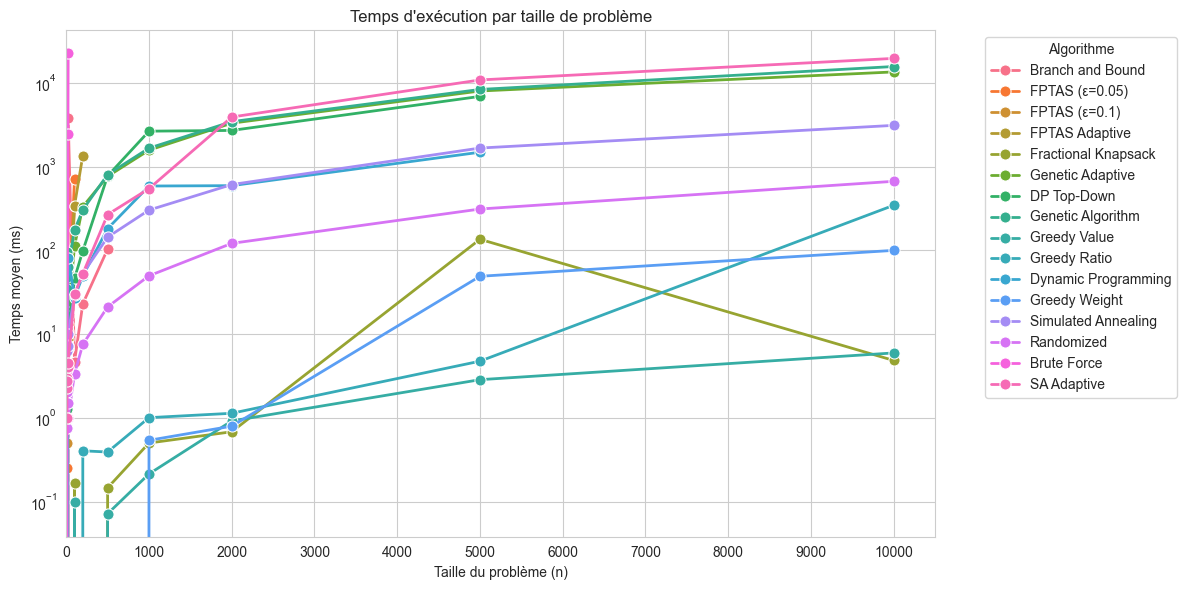

In [20]:
# Graphique 2 : Temps d'exécution par taille n
if results_df is not None:
    df = results_df.copy()
    
    # Moyenne du temps par algorithme et taille n
    agg_time = df.groupby(['algorithm', 'n'])['time_ms'].mean().reset_index()
    
    # Trier par n
    agg_time = agg_time.sort_values('n')
    
    plt.figure(figsize=(12,6))
    
    # Utiliser lineplot avec algorithme comme hue (couleur)
    sns.lineplot(data=agg_time, x='n', y='time_ms', hue='algorithm', marker='o', palette='husl', linewidth=2, markersize=8)
    
    plt.xlabel('Taille du problème (n)')
    plt.ylabel('Temps moyen (ms)')
    plt.title('Temps d\'exécution par taille de problème')
    plt.yscale('log')
    
    # Axe X avec ticks tous les 1000
    max_n = int(agg_time['n'].max())
    plt.xticks(range(0, max_n + 1000, 1000))
    plt.xlim(0, max_n + 500)
    
    plt.legend(title='Algorithme', bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print("results_df non chargé. Exécutez d'abord la cellule qui charge 'benchmark_results.csv'.")

Nombre de fichiers testés par algorithme et taille n:
n                    4      5      7      10     20     23     100    200    500    1000   2000   5000   10000
algorithm                                                                                                     
Branch and Bound         2      1      1      2      2      1     15      5     14      0      0      0      0
Brute Force              2      1      1      2      2      1      0      0      0      0      0      0      0
DP Top-Down              2      1      1      2      2      1     15      5     14     14      9      6      0
Dynamic Programming      2      1      1      2      2      1     15      5     14     14      9      6      0
FPTAS (ε=0.05)           2      1      1      2      2      1     15      0      0      0      0      0      0
FPTAS (ε=0.1)            2      1      1      2      2      1     15      0      0      0      0      0      0
FPTAS Adaptive           2      1      1      2      2    

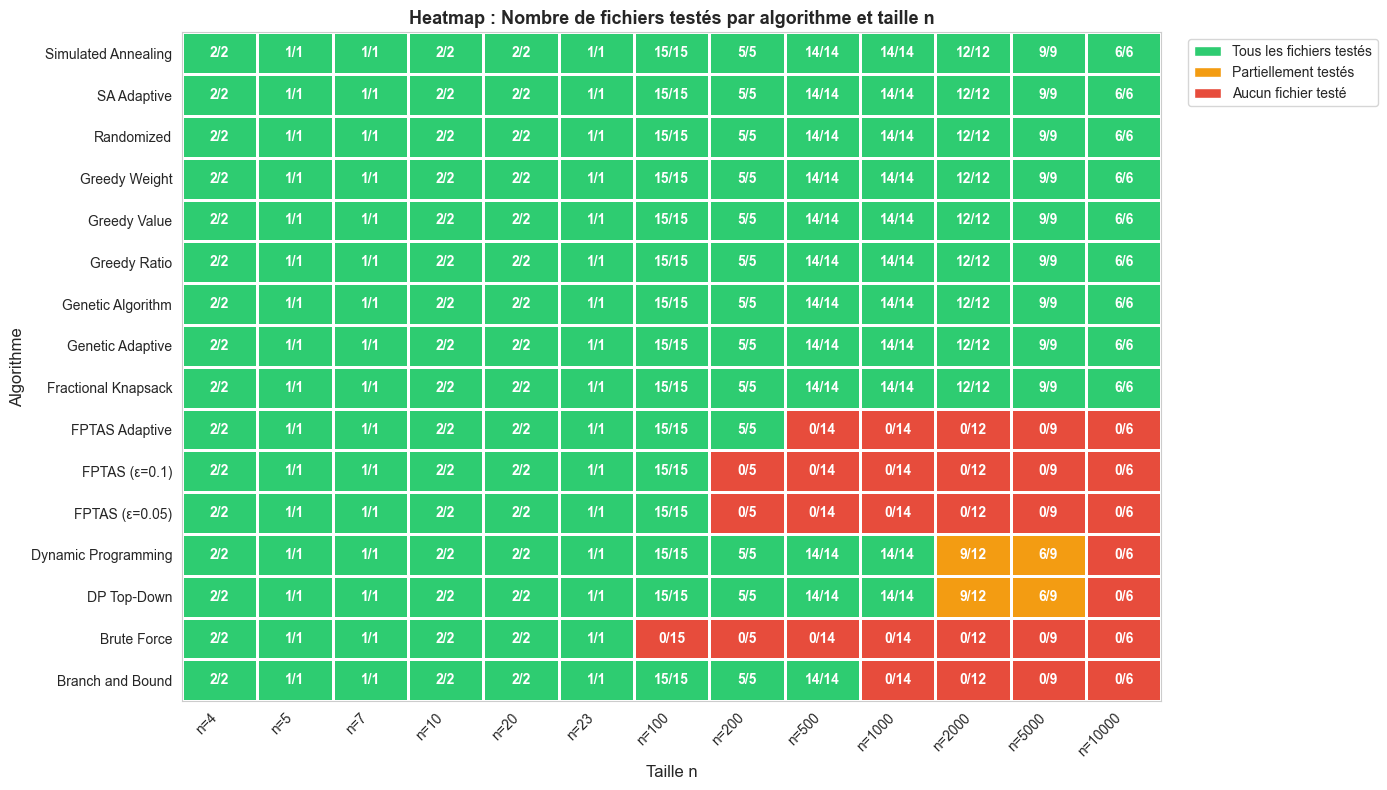

In [21]:
# Graphique 2b : Nombre de fichiers testés par algorithme et taille n
if results_df is not None:
    df = results_df.copy()
    
    # Compter le nombre de fichiers testés par algorithme et taille n
    # Chaque ligne du DataFrame représente un test (un fichier testé par un algorithme)
    file_counts = df.groupby(['algorithm', 'n']).size().reset_index(name='nb_fichiers')
    
    # Créer un tableau pivot pour une meilleure visualisation
    pivot_counts = file_counts.pivot(index='algorithm', columns='n', values='nb_fichiers').fillna(0).astype(int)
    
    # Afficher le tableau
    print("Nombre de fichiers testés par algorithme et taille n:")
    print(pivot_counts.to_string())
    print()
    
    # Réordonner les colonnes du pivot par ordre croissant
    pivot_counts = pivot_counts[sorted(pivot_counts.columns)]
    
    # Calculer le nombre total de fichiers disponibles pour chaque n
    # (le max parmi tous les algorithmes pour chaque n)
    total_files_per_n = pivot_counts.max(axis=0)
    
    # Créer une matrice avec 3 valeurs : 0 = aucun fichier, 1 = partiel, 2 = complet
    status_matrix = np.zeros_like(pivot_counts.values, dtype=float)
    for i in range(len(pivot_counts.index)):
        for j in range(len(pivot_counts.columns)):
            n_col = pivot_counts.columns[j]
            val = pivot_counts.values[i, j]
            total = total_files_per_n[n_col]
            if val >= total and total > 0:
                status_matrix[i, j] = 2  # Vert (tous les fichiers)
            elif val > 0:
                status_matrix[i, j] = 1  # Jaune (partiel)
            else:
                status_matrix[i, j] = 0  # Rouge (aucun fichier)
    
    # Graphique Heatmap avec 3 couleurs
    from matplotlib.colors import ListedColormap
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Colormap personnalisé : rouge (0), jaune (1), vert (2)
    cmap_3colors = ListedColormap(['#e74c3c', '#f39c12', '#2ecc71'])  # Rouge, Jaune, Vert
    
    # Utiliser pcolormesh avec le colormap à 3 couleurs
    im = ax.pcolormesh(status_matrix, cmap=cmap_3colors, edgecolors='white', linewidth=2, vmin=0, vmax=2)
    
    # Axes - centrer les ticks au milieu des cellules
    ax.set_xticks(np.arange(len(pivot_counts.columns)) + 0.5)
    ax.set_yticks(np.arange(len(pivot_counts.index)) + 0.5)
    ax.set_xticklabels([f'n={n}' for n in pivot_counts.columns], fontsize=10)
    ax.set_yticklabels(pivot_counts.index, fontsize=10)
    
    # Rotation des labels x
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    # Ajouter les valeurs dans chaque cellule (centré dans chaque case)
    for i in range(len(pivot_counts.index)):
        for j in range(len(pivot_counts.columns)):
            val = int(pivot_counts.values[i, j])
            n_col = pivot_counts.columns[j]
            total = int(total_files_per_n[n_col])
            # Texte blanc pour meilleure lisibilité sur les couleurs
            ax.text(j + 0.5, i + 0.5, f'{val}/{total}', ha='center', va='center', 
                   color='white', fontsize=10, fontweight='bold')
    
    ax.set_xlabel('Taille n', fontsize=12)
    ax.set_ylabel('Algorithme', fontsize=12)
    ax.set_title('Heatmap : Nombre de fichiers testés par algorithme et taille n', fontsize=13, fontweight='bold')
    
    # Légende personnalisée au lieu d'une colorbar
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#2ecc71', edgecolor='white', label='Tous les fichiers testés'),
        Patch(facecolor='#f39c12', edgecolor='white', label='Partiellement testés'),
        Patch(facecolor='#e74c3c', edgecolor='white', label='Aucun fichier testé')
    ]
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=10)
    
    plt.tight_layout()
    plt.show()
else:
    print("results_df non chargé.")

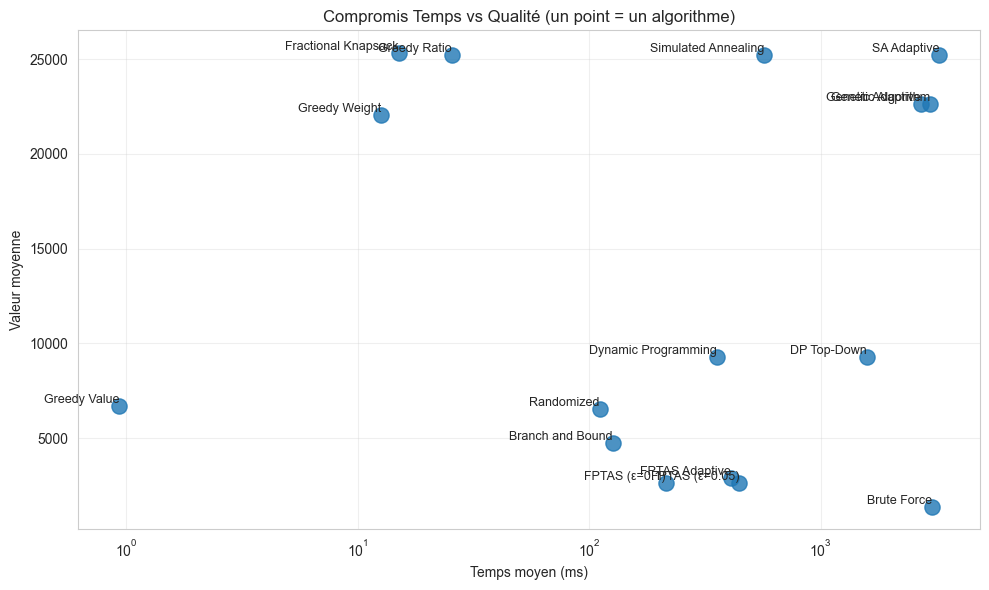

In [22]:
# Graphique 3 : Scatter Temps (X) vs Valeur (Y), 1 point = 1 algorithme (moyennes), annoté
if results_df is not None:
    df = results_df.copy()
    # prendre la moyenne temps et valeur par algorithme
    summary = df.groupby('algorithm').agg({'time_ms':'mean','value':'mean'}).reset_index()
    
    plt.figure(figsize=(10,6))
    plt.scatter(summary['time_ms'], summary['value'], s=120, alpha=0.8)
    for i, row in summary.iterrows():
        plt.text(row['time_ms'], row['value'], row['algorithm'], fontsize=9,
                 verticalalignment='bottom', horizontalalignment='right')
    plt.xscale('log')
    plt.xlabel('Temps moyen (ms)')
    plt.ylabel('Valeur moyenne')
    plt.title('Compromis Temps vs Qualité (un point = un algorithme)')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("results_df non chargé. Exécutez d'abord la cellule qui charge 'benchmark_results.csv'.")

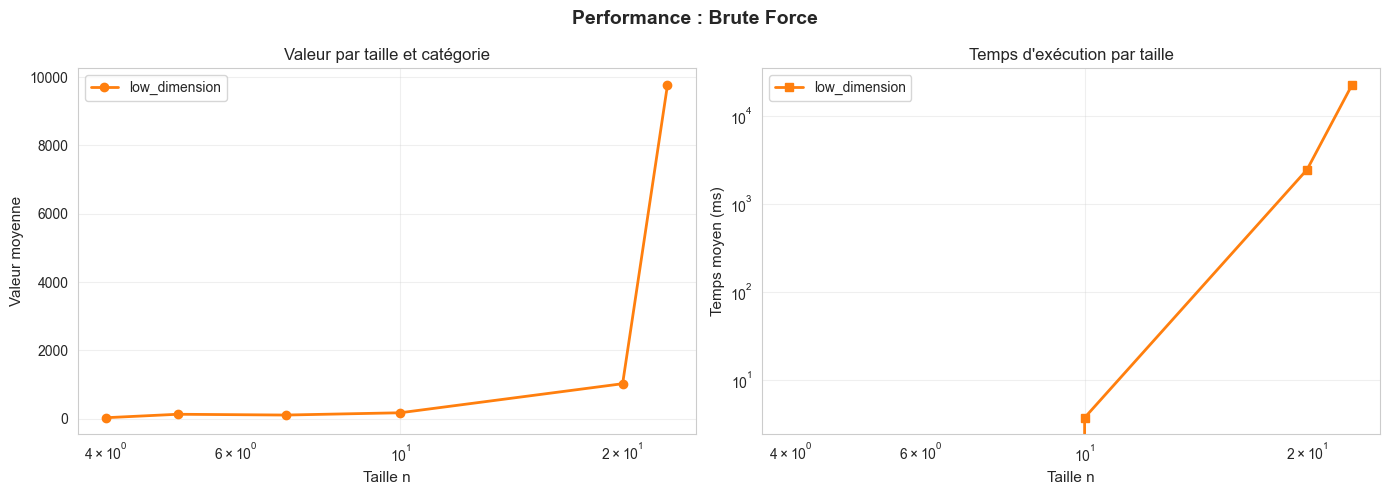

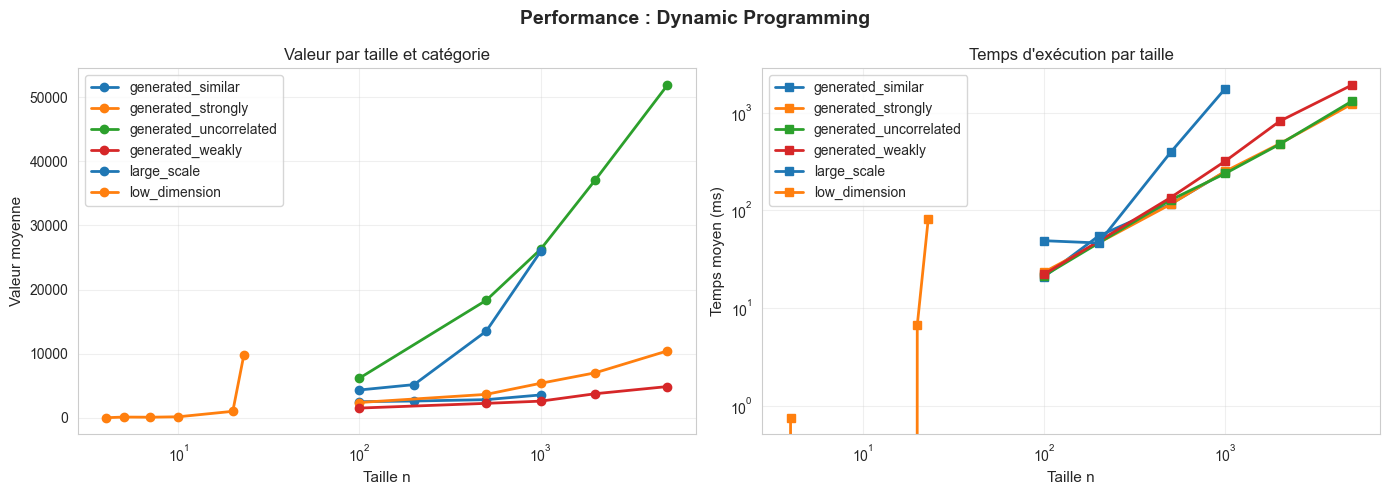

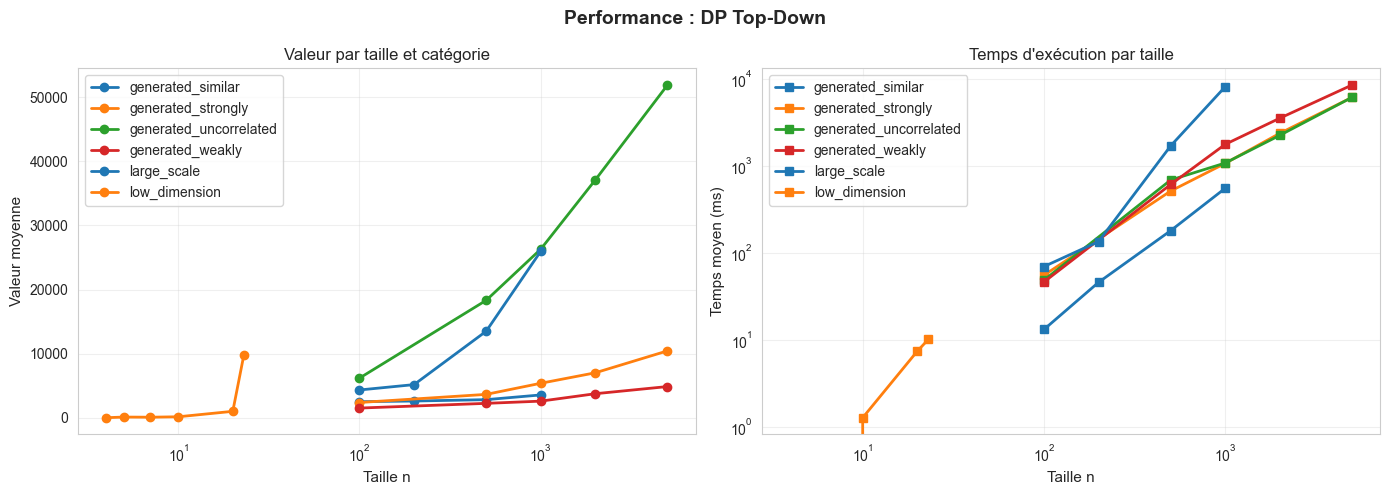

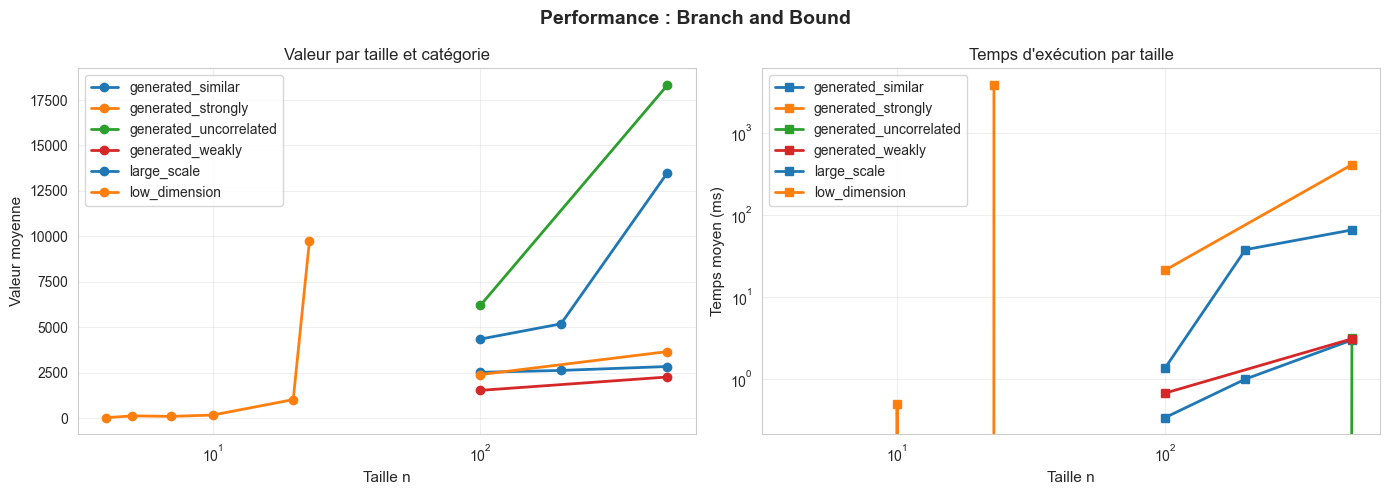

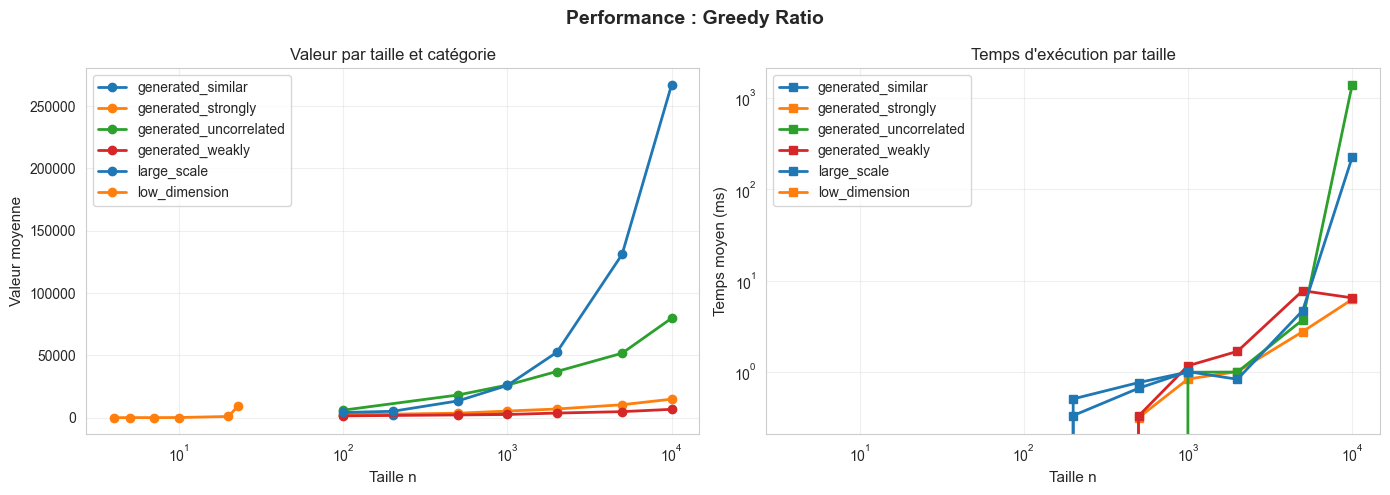

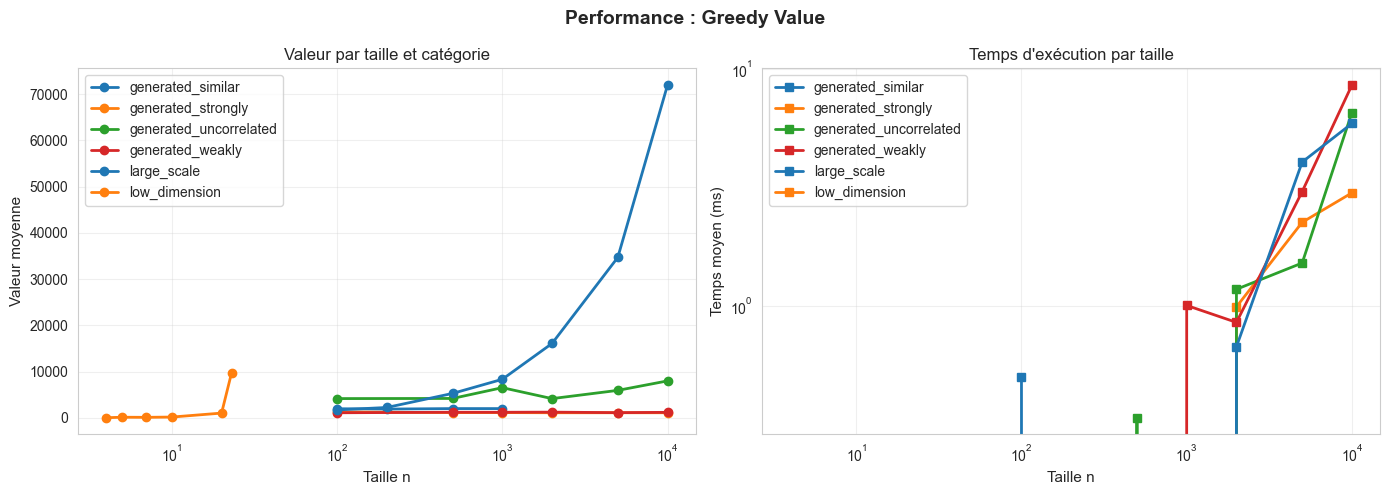

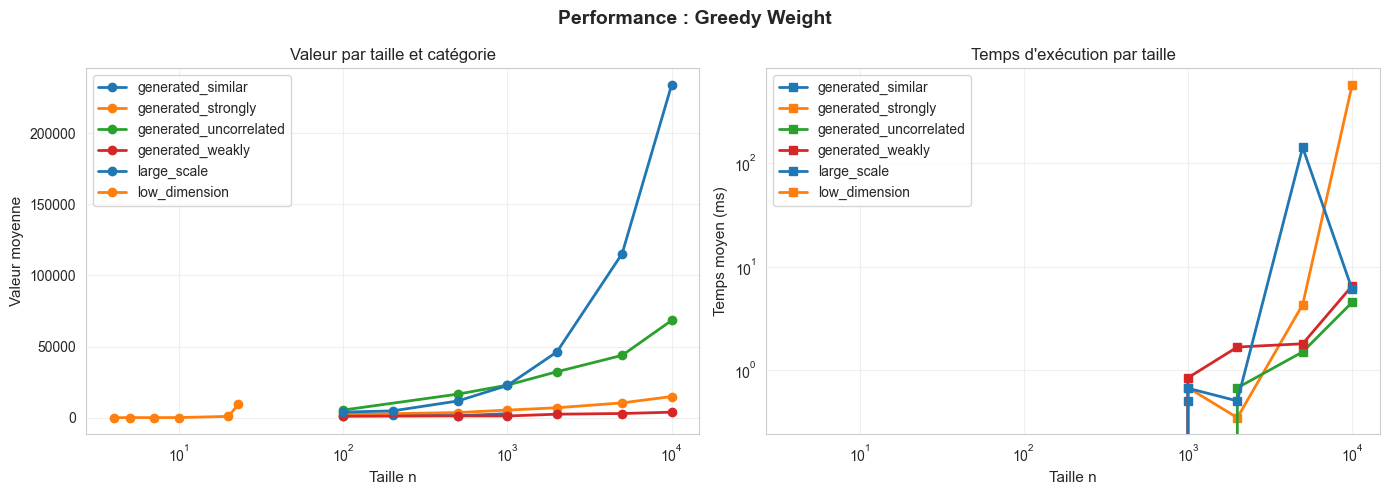

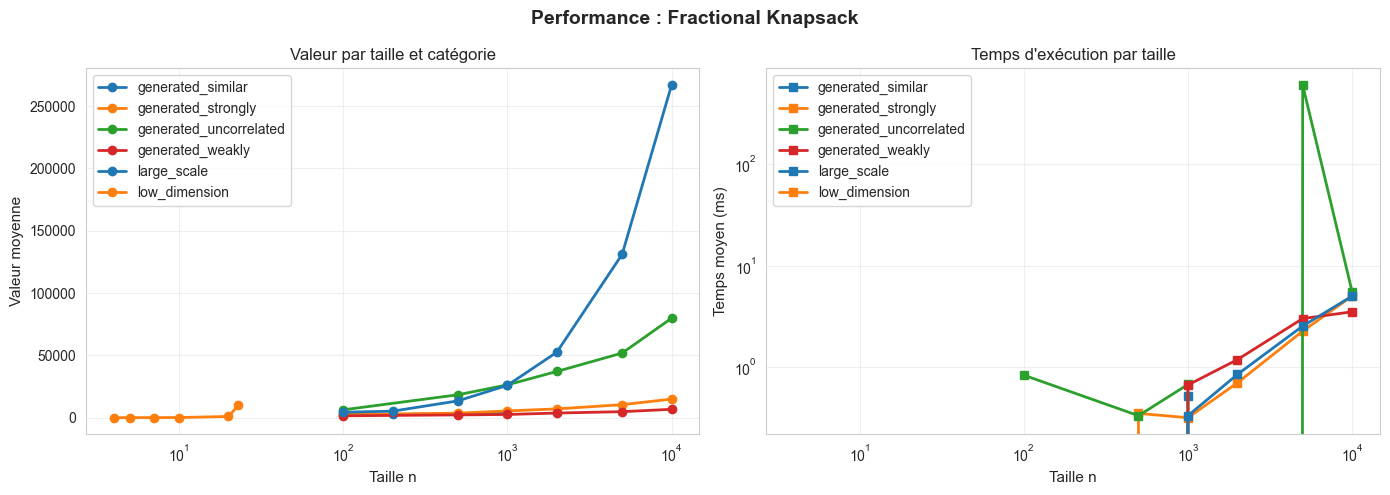

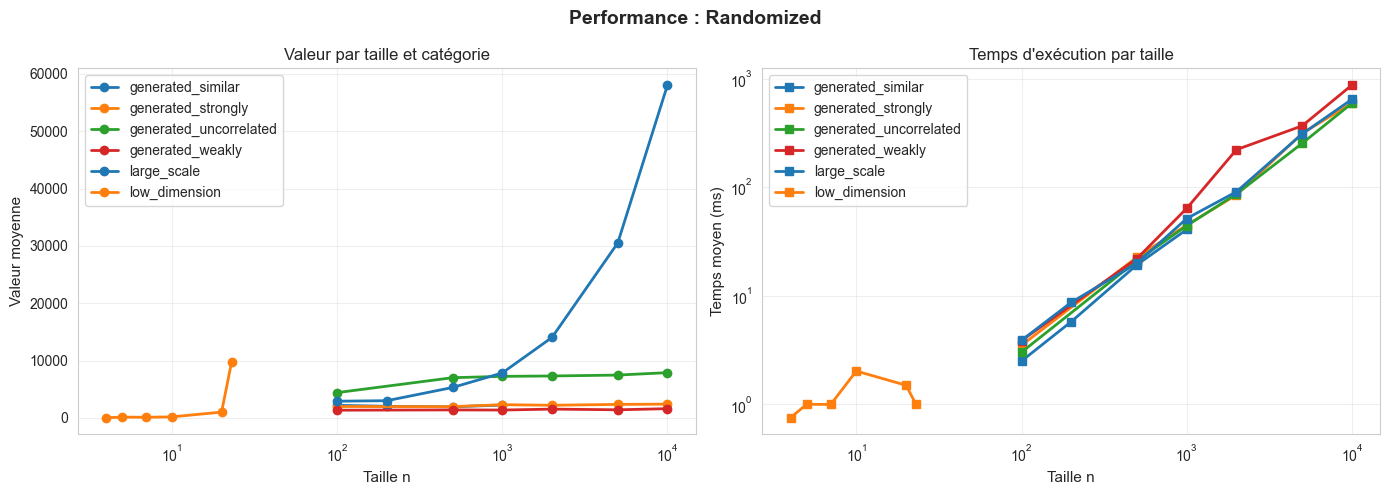

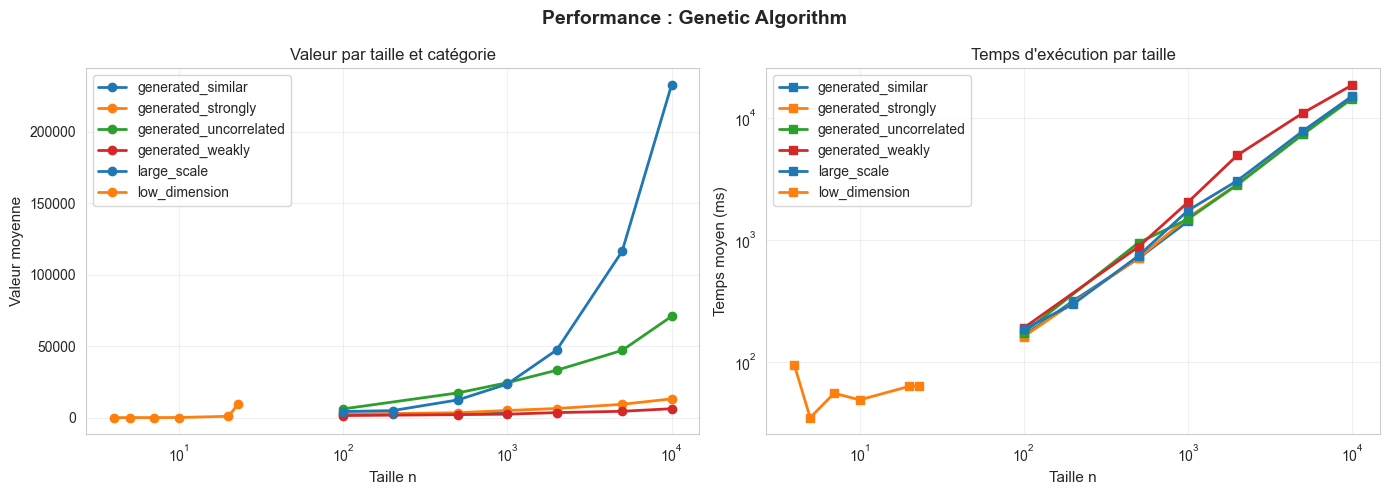

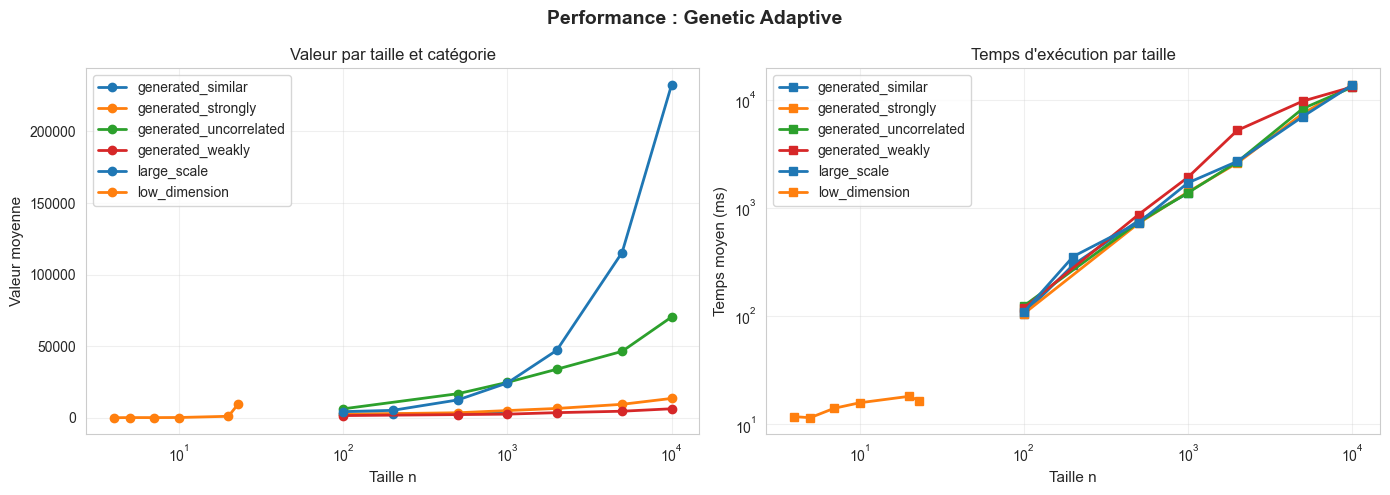

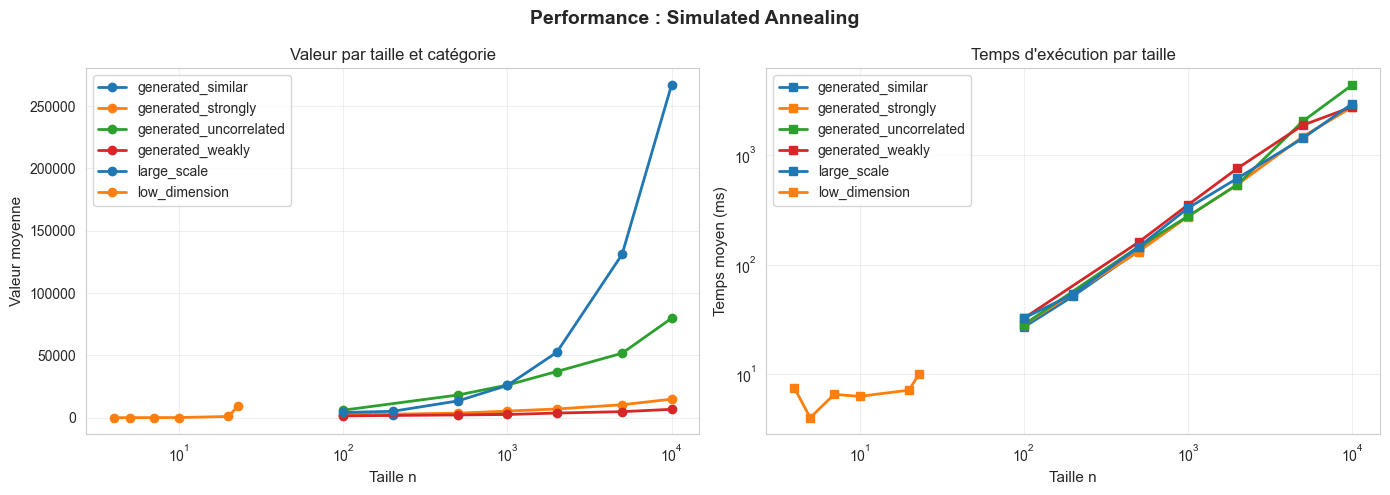

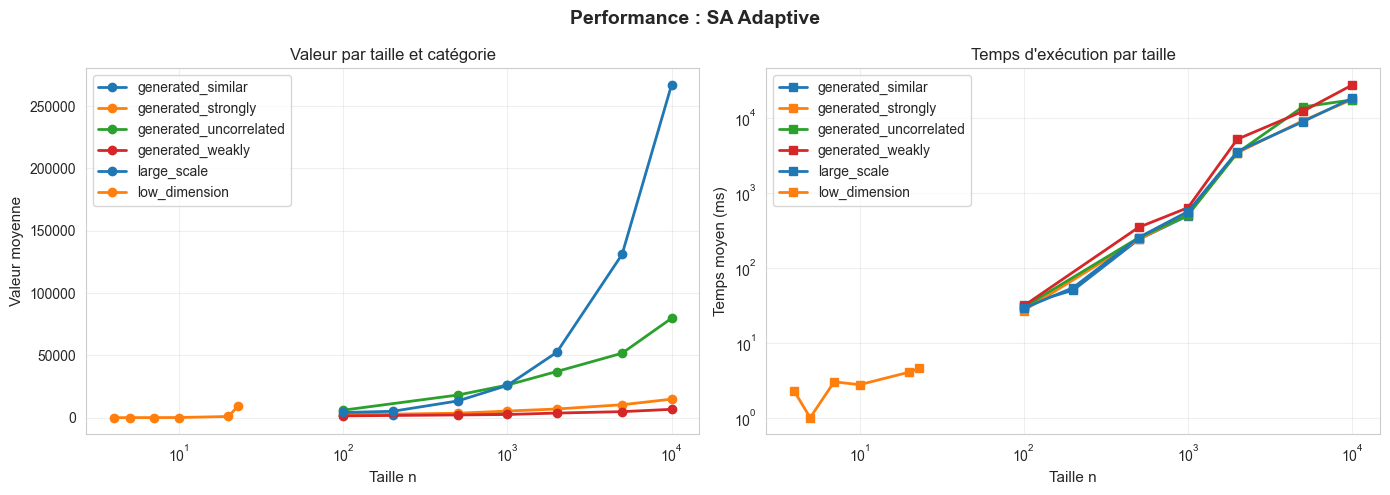

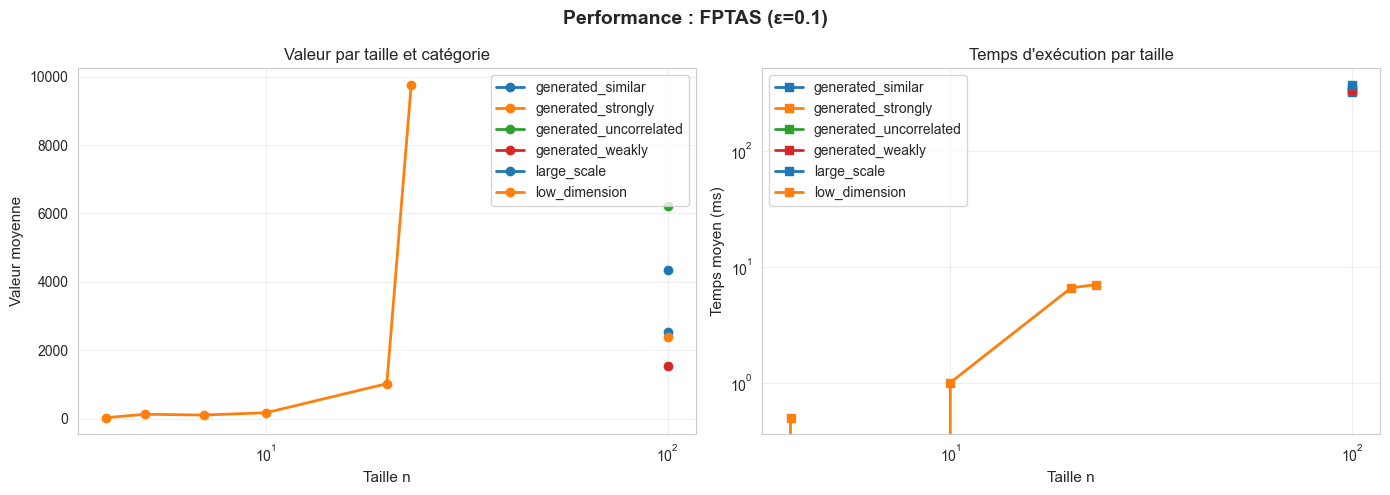

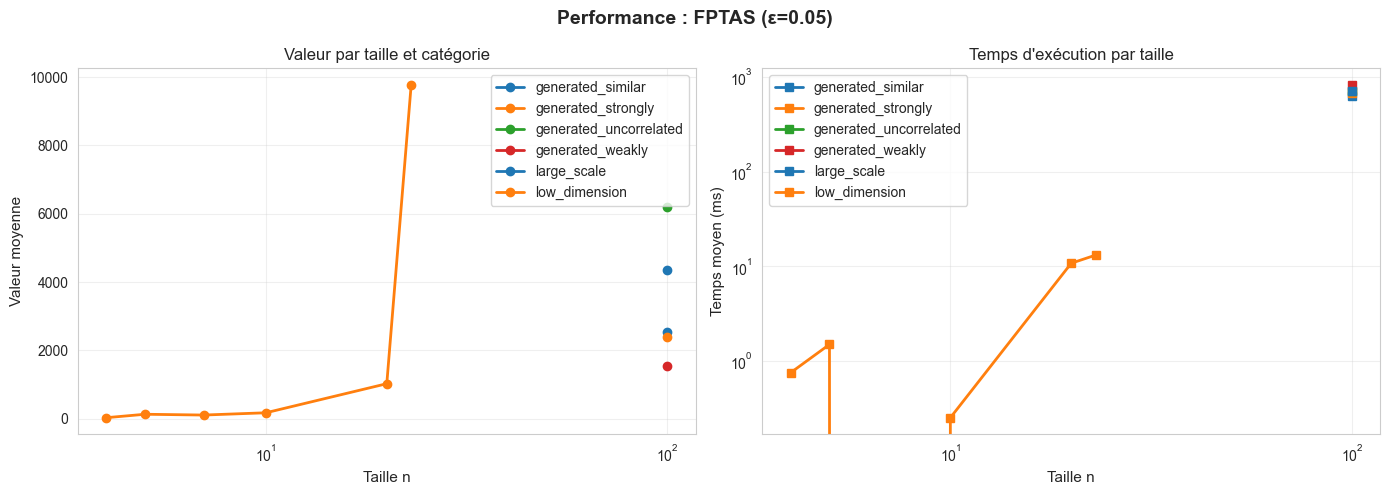

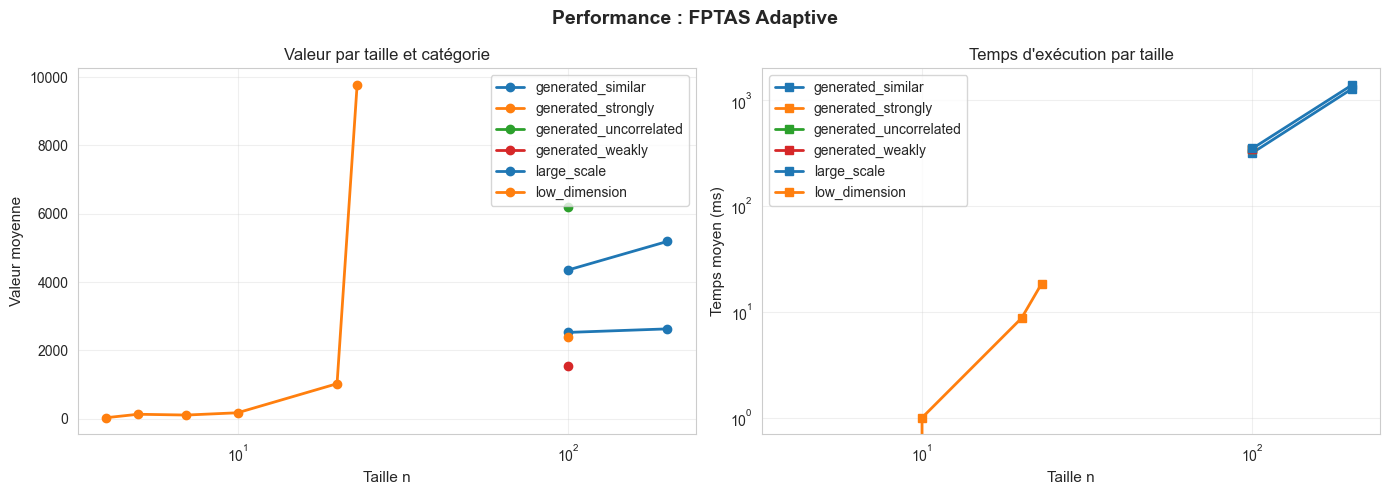

In [23]:
if results_df is not None:
    df = results_df.copy()
    
    algorithms = df['algorithm'].unique()
    
    # couleurs pour les deux catégories principales
    colors_cat = {'large_scale':'#1f77b4','low_dimension':'#ff7f0e'}
    
    for algo in algorithms:
        algo_data = df[df['algorithm'] == algo].copy()
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        fig.suptitle(f'Performance : {algo}', fontsize=14, fontweight='bold')
        
        # Valeur par catégorie et taille n
        if 'category' in algo_data.columns:
            agg_value = algo_data.groupby(['category', 'n'])['value'].mean().reset_index()
            groups = agg_value['category'].unique()
        else:
            # fallback vers 'correlation' si présent
            agg_value = algo_data.groupby(['correlation', 'n'])['value'].mean().reset_index()
            agg_value = agg_value.rename(columns={'correlation':'category'})
            groups = agg_value['category'].unique()

        for cat in groups:
            cat_data = agg_value[agg_value['category'] == cat]
            axes[0].plot(cat_data['n'], cat_data['value'], marker='o', label=cat, linewidth=2,
                         color=colors_cat.get(cat, None))
        
        axes[0].set_xlabel('Taille n', fontsize=11)
        axes[0].set_ylabel('Valeur moyenne', fontsize=11)
        axes[0].set_title('Valeur par taille et catégorie')
        axes[0].legend()
        axes[0].grid(alpha=0.3)
        axes[0].set_xscale('log')
        
        # Temps d'exécution par taille n
        if 'category' in algo_data.columns:
            agg_time = algo_data.groupby(['category', 'n'])['time_ms'].mean().reset_index()
        else:
            agg_time = algo_data.groupby(['correlation', 'n'])['time_ms'].mean().reset_index()
            agg_time = agg_time.rename(columns={'correlation':'category'})

        for cat in agg_time['category'].unique():
            cat_data = agg_time[agg_time['category'] == cat]
            axes[1].plot(cat_data['n'], cat_data['time_ms'], marker='s', label=cat, linewidth=2,
                         color=colors_cat.get(cat, None))
        
        axes[1].set_xlabel('Taille n', fontsize=11)
        axes[1].set_ylabel('Temps moyen (ms)', fontsize=11)
        axes[1].set_title('Temps d\'exécution par taille')
        axes[1].legend()
        axes[1].grid(alpha=0.3)
        axes[1].set_xscale('log')
        axes[1].set_yscale('log')
        
        plt.tight_layout()
        plt.show()
        print(f"\n{'='*60}\n")
else:
    print("results_df non chargé. Exécutez d'abord la cellule qui charge 'benchmark_results.csv'.")

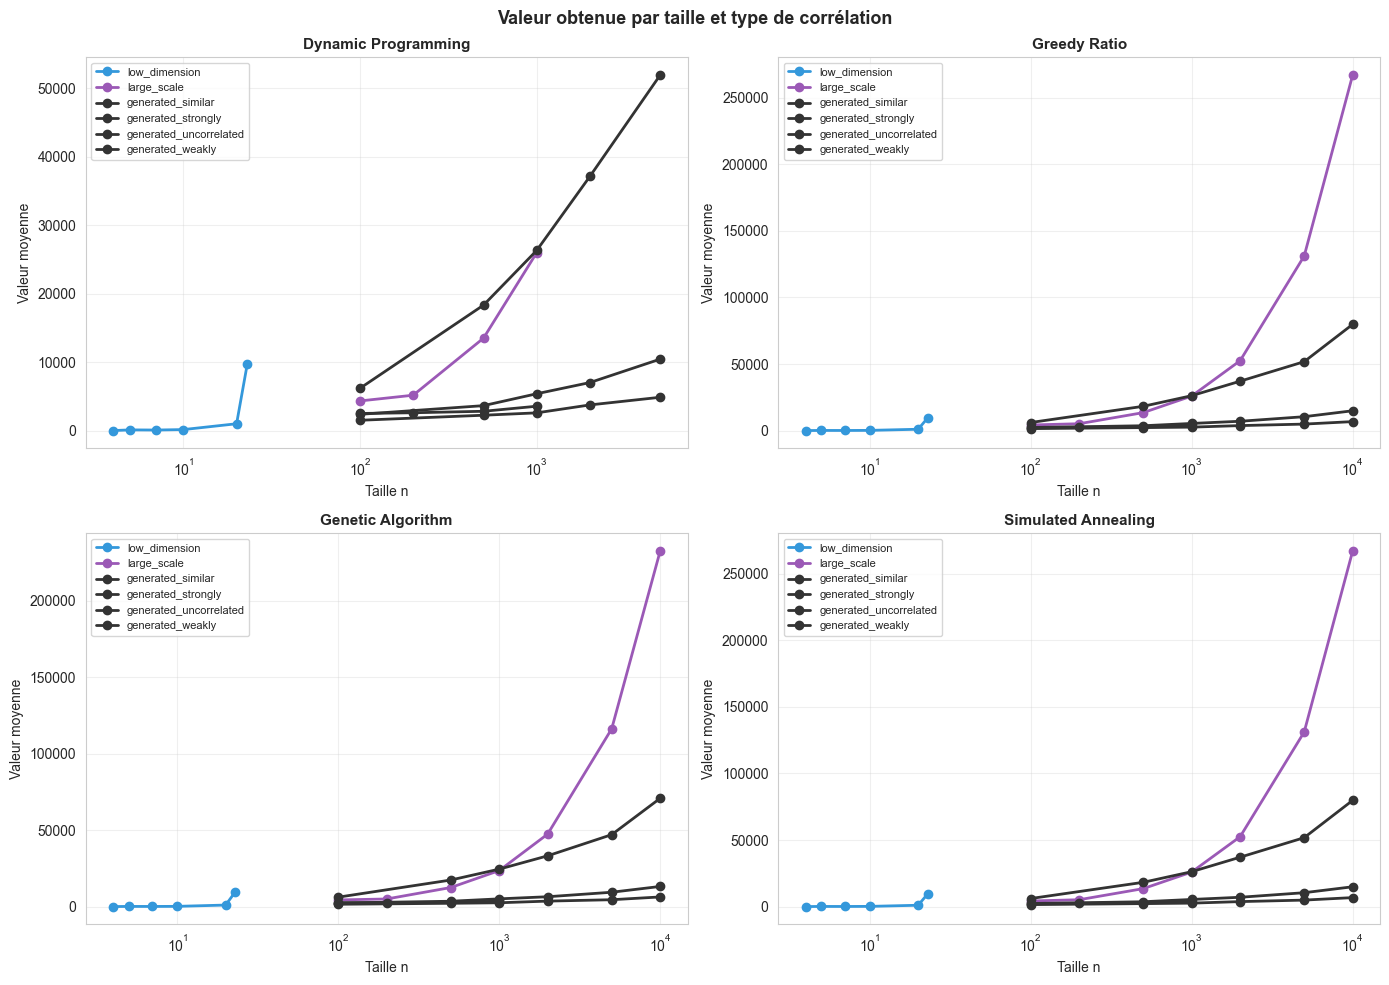

In [24]:
# Graphique 5 : Évolution des performances selon n pour chaque type de corrélation
if results_df is not None:
    df = results_df.copy()
    
    # Palette de couleurs pour les corrélations
    corr_colors = {
        'uncorrelated': '#2ecc71',
        'weakly_correlated': '#f39c12', 
        'strongly_correlated': '#e74c3c',
        'low_dimension': '#3498db',
        'large_scale': '#9b59b6'
    }
    
    # Sélectionner quelques algorithmes représentatifs pour la lisibilité
    algos_to_show = ['Dynamic Programming', 'Greedy Ratio', 'Genetic Algorithm', 'Simulated Annealing']
    algos_present = [a for a in algos_to_show if a in df['algorithm'].unique()]
    
    if len(algos_present) > 0:
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        axes = axes.flatten()
        
        for idx, algo in enumerate(algos_present[:4]):
            ax = axes[idx]
            algo_data = df[df['algorithm'] == algo]
            
            for corr in algo_data['correlation'].unique():
                corr_data = algo_data[algo_data['correlation'] == corr]
                agg = corr_data.groupby('n').agg({'value': 'mean', 'time_ms': 'mean'}).reset_index()
                agg = agg.sort_values('n')
                
                color = corr_colors.get(corr, '#333')
                ax.plot(agg['n'], agg['value'], 'o-', label=corr, color=color, linewidth=2, markersize=6)
            
            ax.set_xlabel('Taille n', fontsize=10)
            ax.set_ylabel('Valeur moyenne', fontsize=10)
            ax.set_title(f'{algo}', fontsize=11, fontweight='bold')
            ax.legend(fontsize=8)
            ax.grid(alpha=0.3)
            ax.set_xscale('log')
        
        plt.suptitle('Valeur obtenue par taille et type de corrélation', fontsize=13, fontweight='bold')
        plt.tight_layout()
        plt.show()
else:
    print("results_df non chargé.")

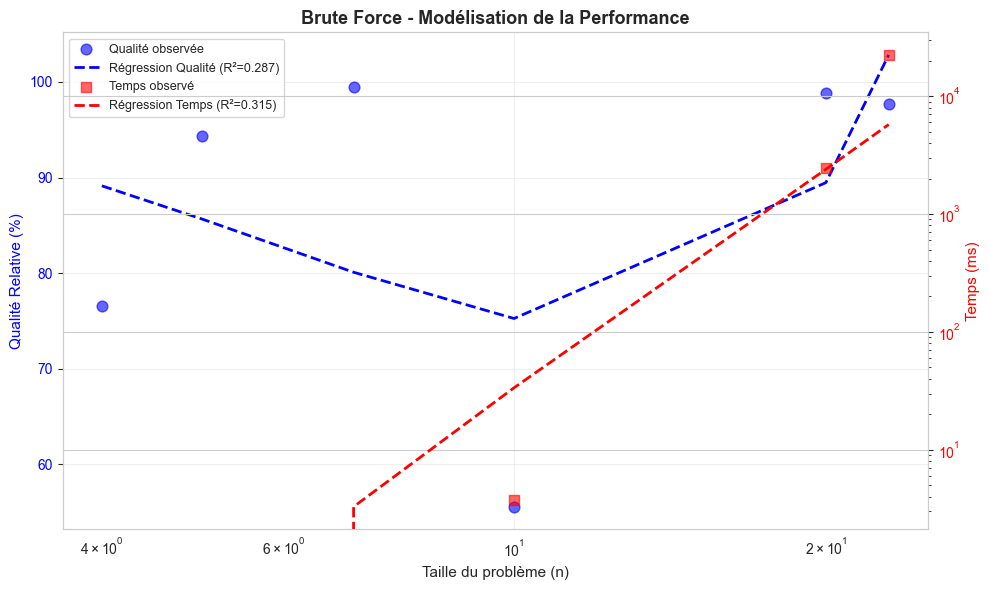

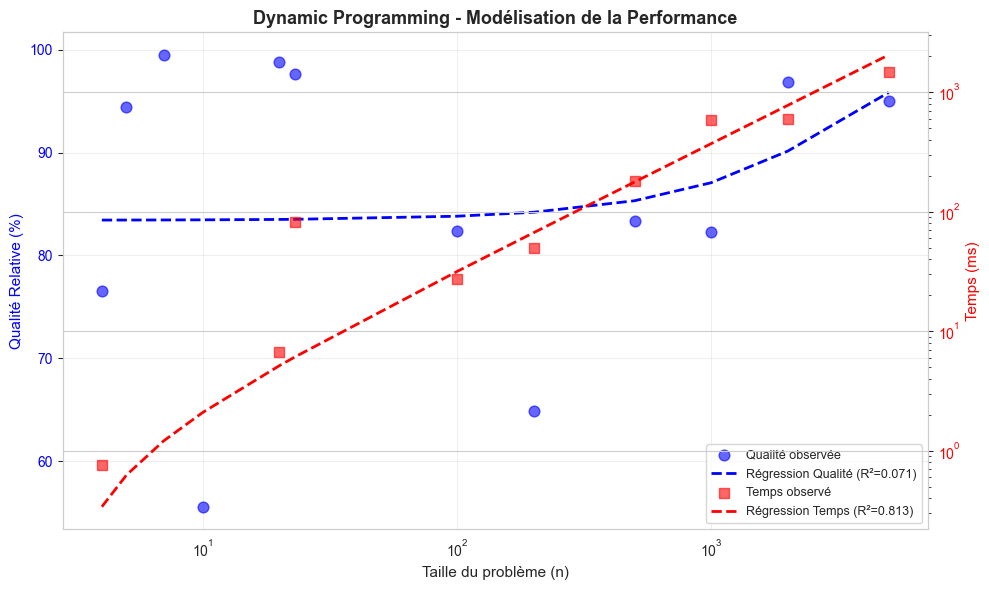

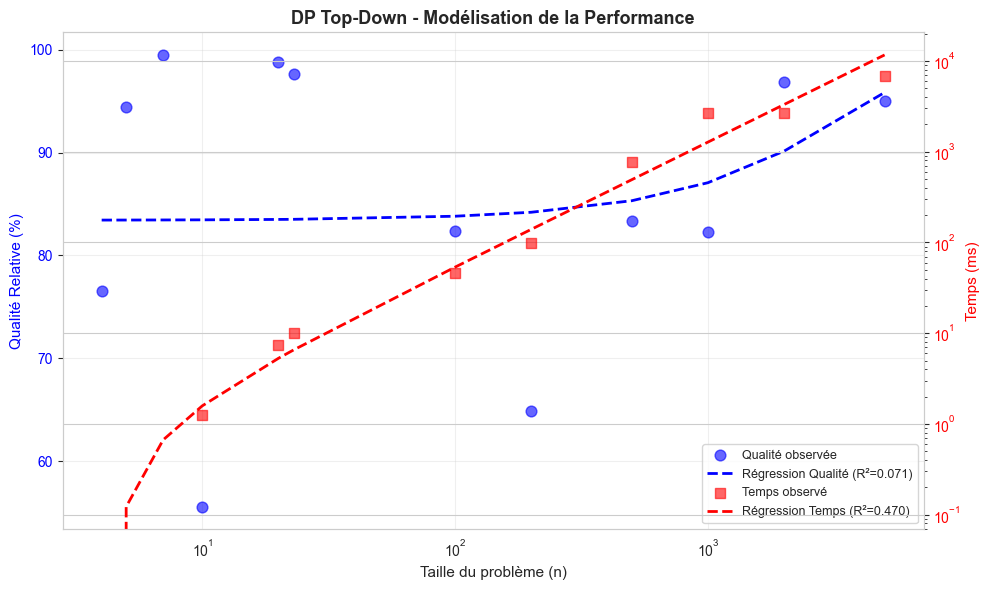

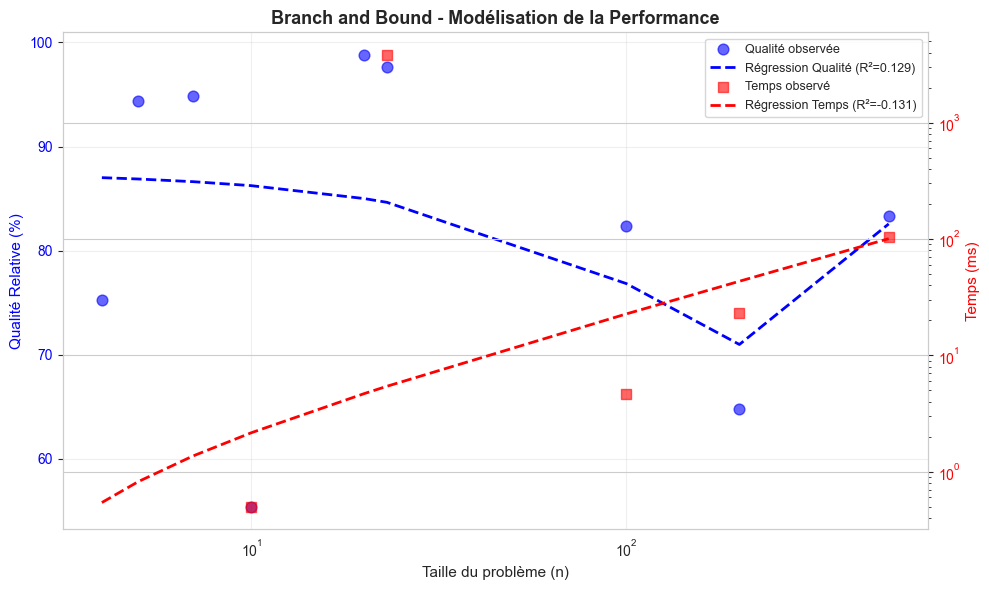

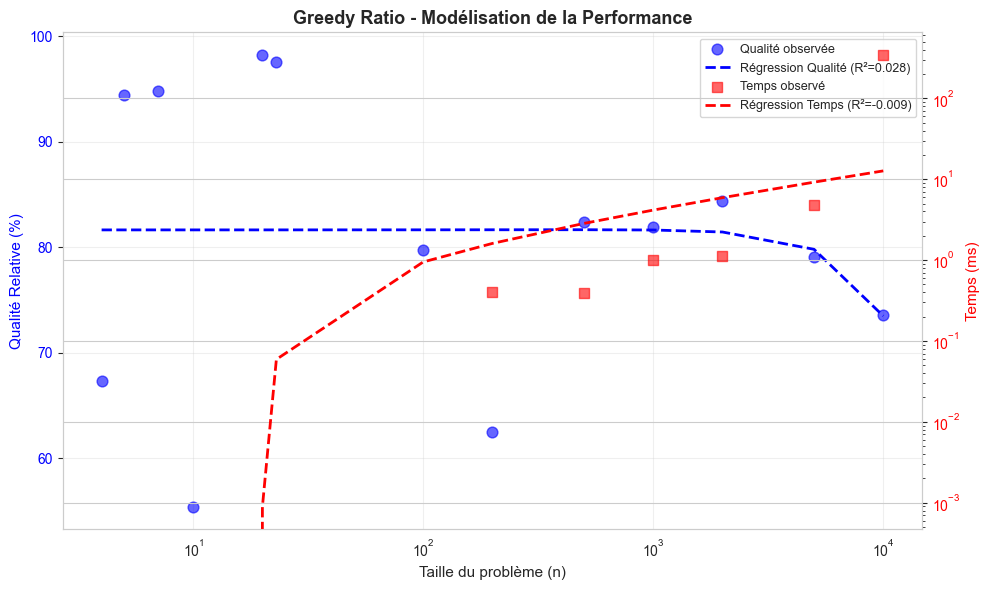

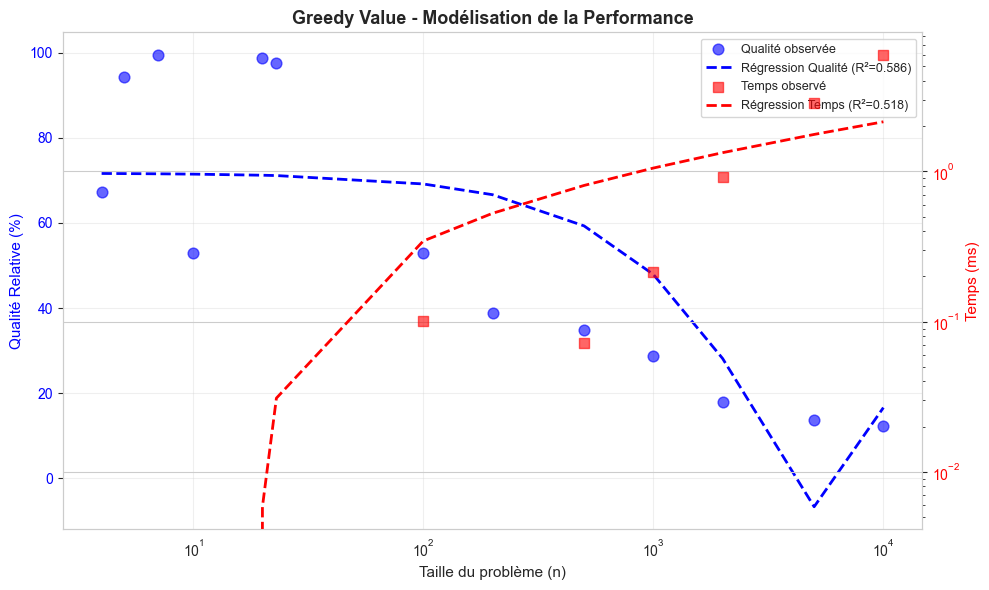

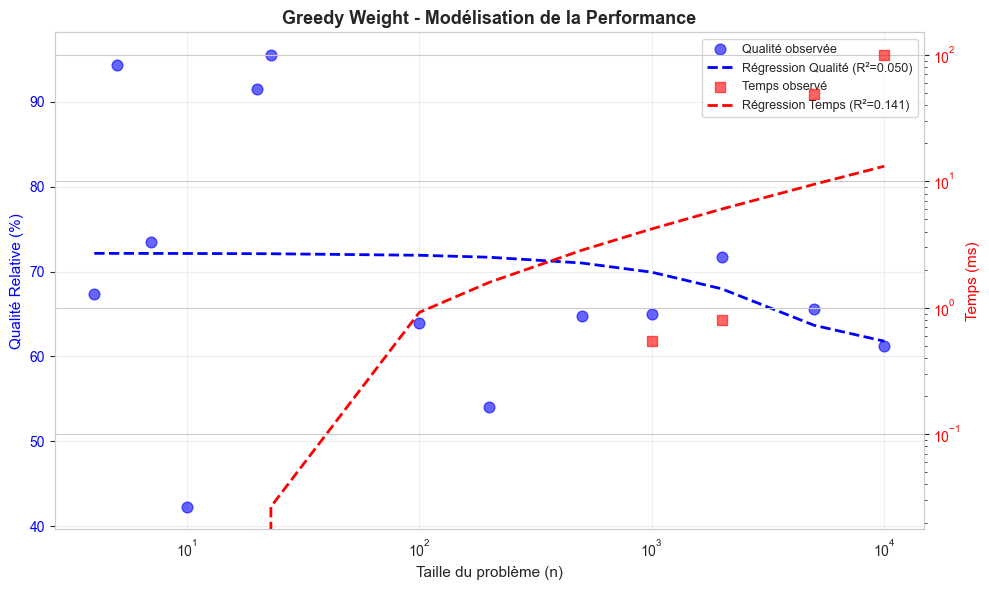

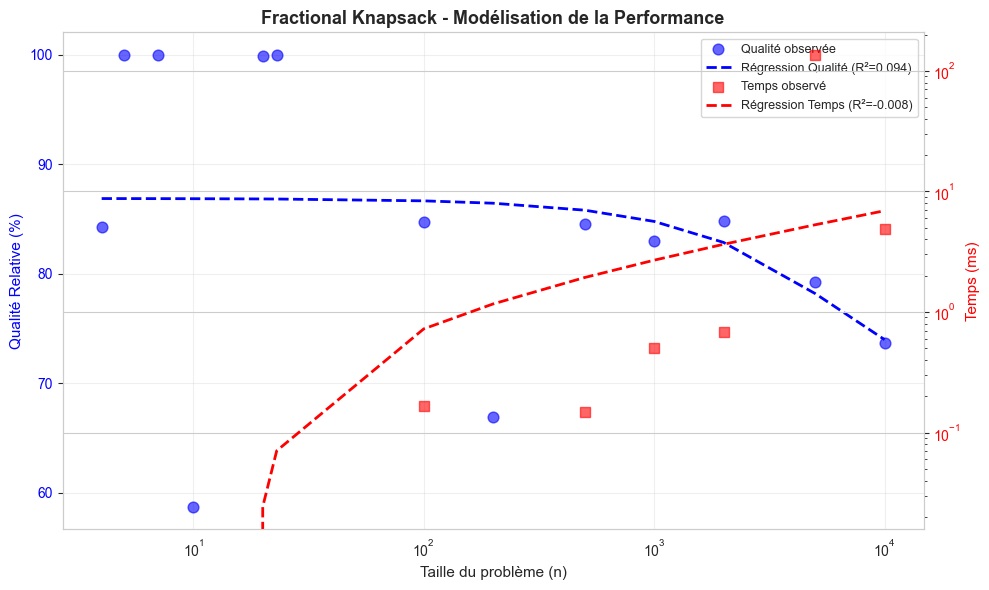

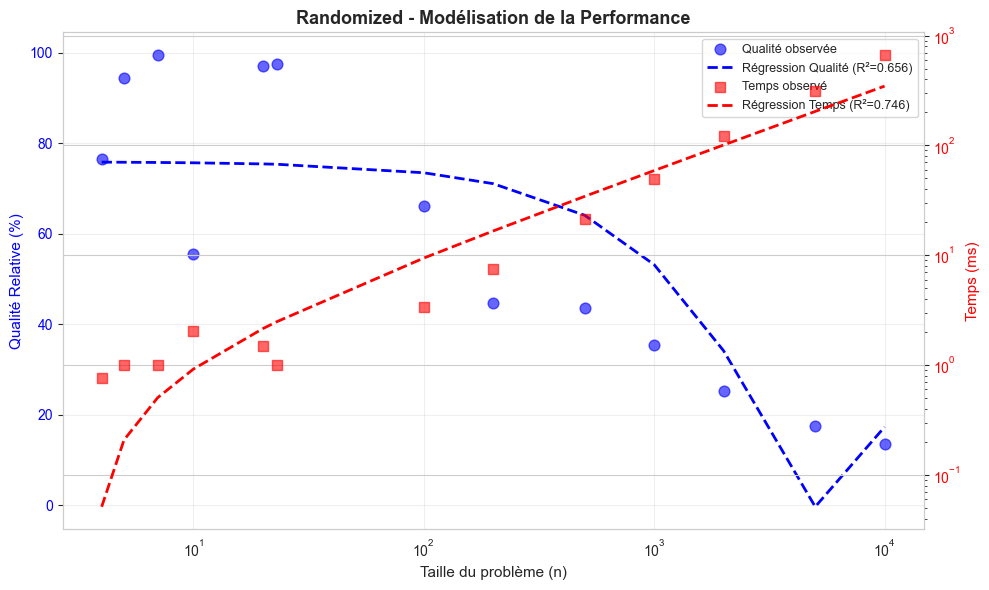

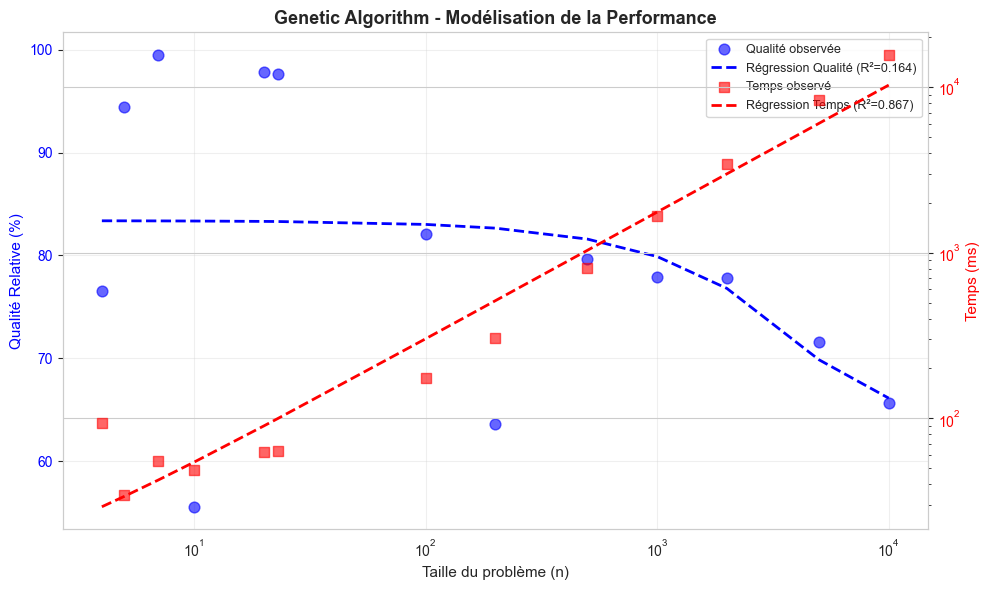

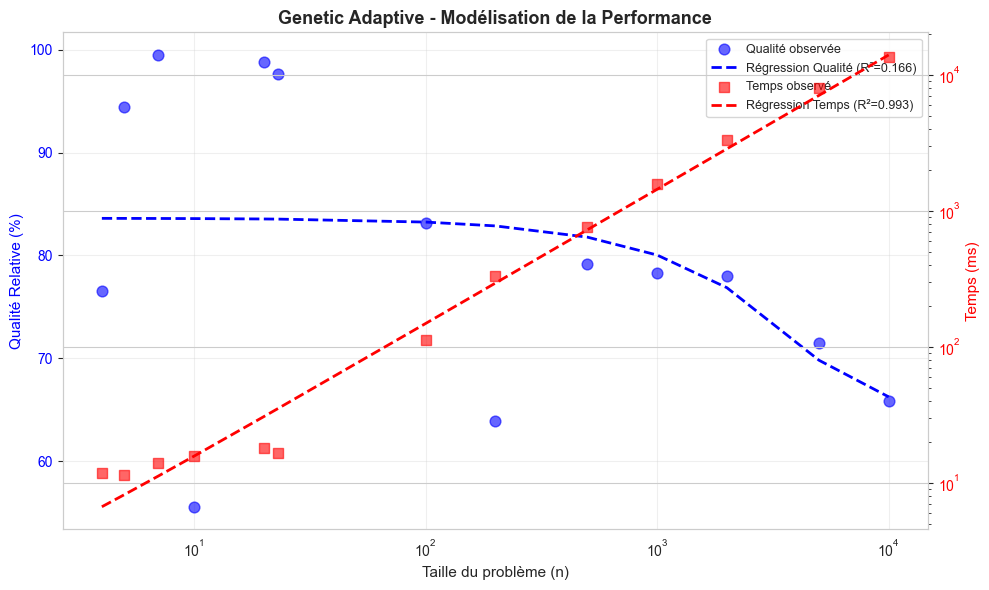

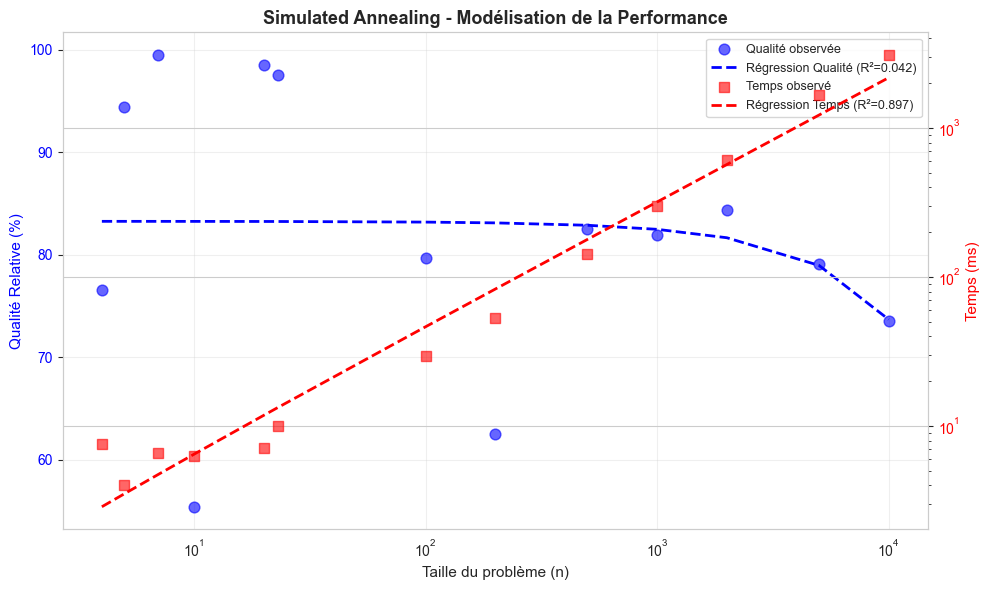

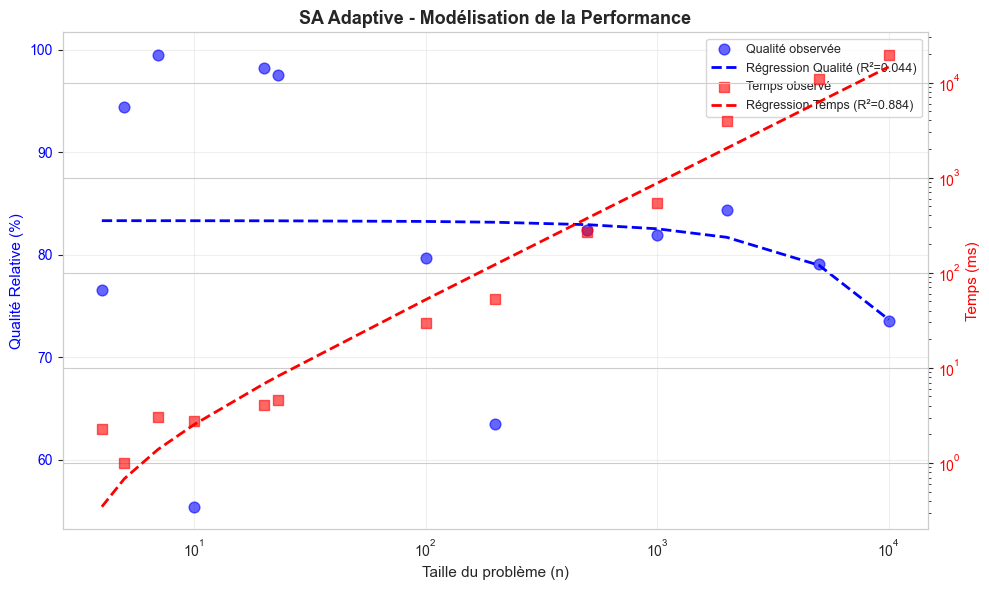

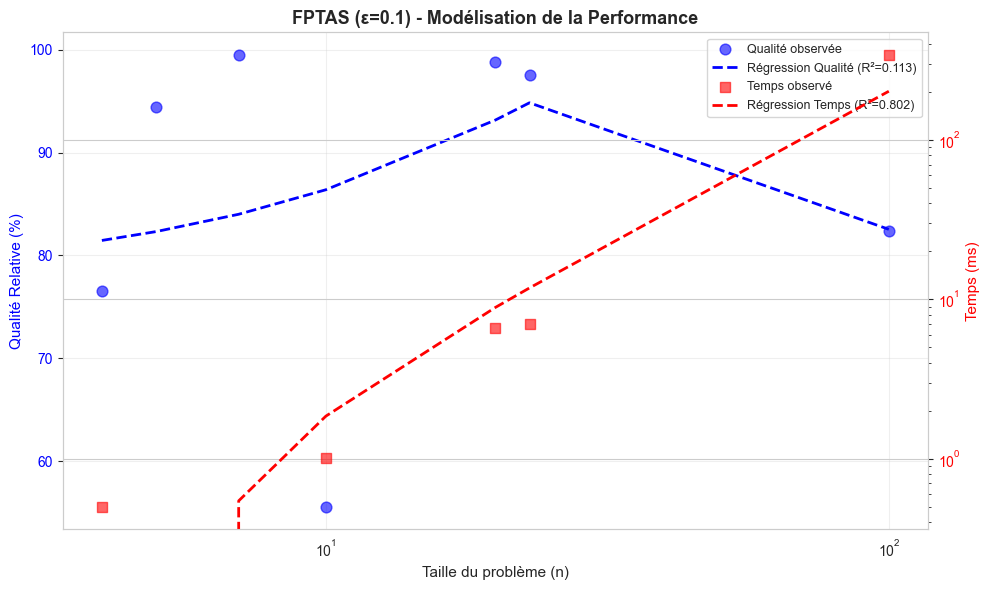

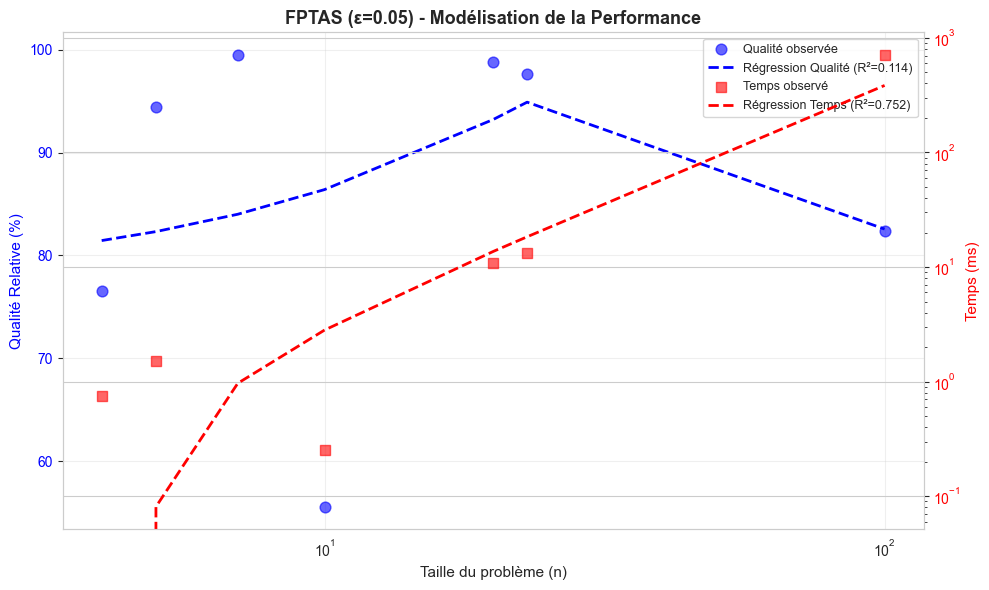

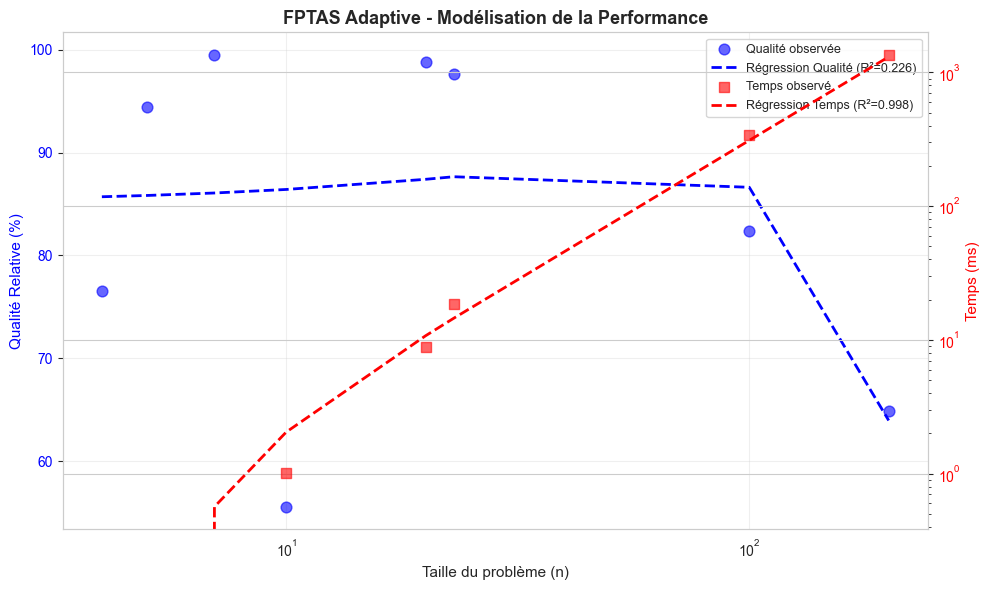


ANALYSE DE RÉGRESSION - MODÉLISATION DE LA PERFORMANCE

Brute Force:
  Qualité: R² = 0.287 (tendance: décroissant)
  Temps: R² = 0.315 (complexité estimée: O(n^6.55))

Dynamic Programming:
  Qualité: R² = 0.071 (tendance: croissant)
  Temps: R² = 0.813 (complexité estimée: O(n^1.06))

DP Top-Down:
  Qualité: R² = 0.071 (tendance: croissant)
  Temps: R² = 0.470 (complexité estimée: O(n^1.38))

Branch and Bound:
  Qualité: R² = 0.129 (tendance: décroissant)
  Temps: R² = -0.131 (complexité estimée: O(n^0.91))

Greedy Ratio:
  Qualité: R² = 0.028 (tendance: croissant)
  Temps: R² = -0.009 (complexité estimée: O(n^0.42))

Greedy Value:
  Qualité: R² = 0.586 (tendance: décroissant)
  Temps: R² = 0.518 (complexité estimée: O(n^0.18))

Greedy Weight:
  Qualité: R² = 0.050 (tendance: décroissant)
  Temps: R² = 0.141 (complexité estimée: O(n^0.43))

Fractional Knapsack:
  Qualité: R² = 0.094 (tendance: décroissant)
  Temps: R² = -0.008 (complexité estimée: O(n^0.33))

Randomized:
  Qualité: R²

In [25]:
if results_df is not None:
    from sklearn.linear_model import LinearRegression
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.metrics import r2_score
    import warnings
    warnings.filterwarnings('ignore')
    
    df = results_df.copy()
    
    # Normaliser la qualité
    df['max_value_per_instance'] = df.groupby(['n', 'correlation'])['value'].transform('max')
    df['relative_quality'] = (df['value'] / df['max_value_per_instance']) * 100
    
    # Prendre tous les algorithmes présents dans les données
    all_algos = df['algorithm'].unique().tolist()
    
    regression_results = []
    
    # Un graphique séparé pour chaque algorithme
    for algo in all_algos:
        algo_data = df[df['algorithm'] == algo].copy()
        
        if len(algo_data) == 0:
            continue
        
        # Grouper par taille
        grouped = algo_data.groupby('n').agg({
            'relative_quality': 'mean',
            'time_ms': 'mean'
        }).reset_index().sort_values('n')
        
        if len(grouped) < 2:
            continue
        
        X = grouped['n'].values.reshape(-1, 1)
        y_quality = grouped['relative_quality'].values
        y_time = grouped['time_ms'].values
        
        # Régression polynomiale pour la qualité
        poly_features = PolynomialFeatures(degree=2)
        X_poly = poly_features.fit_transform(X)
        
        reg_quality = LinearRegression()
        reg_quality.fit(X_poly, y_quality)
        y_pred_quality = reg_quality.predict(X_poly)
        r2_quality = r2_score(y_quality, y_pred_quality)
        
        # Régression pour le temps (log-log)
        X_log = np.log1p(X)
        y_log = np.log1p(y_time)
        reg_time = LinearRegression()
        reg_time.fit(X_log, y_log)
        y_pred_time = np.expm1(reg_time.predict(X_log))
        r2_time = r2_score(y_time, y_pred_time)
        
        # Créer un graphique individuel pour cet algorithme
        fig, ax = plt.subplots(figsize=(10, 6))
        ax2 = ax.twinx()
        
        # Qualité
        ax.scatter(grouped['n'], grouped['relative_quality'], color='blue', 
                  alpha=0.6, s=60, label='Qualité observée', zorder=3)
        ax.plot(grouped['n'], y_pred_quality, 'b--', linewidth=2, 
               label=f'Régression Qualité (R²={r2_quality:.3f})', zorder=2)
        ax.set_xlabel('Taille du problème (n)', fontsize=11)
        ax.set_ylabel('Qualité Relative (%)', fontsize=11, color='blue')
        ax.tick_params(axis='y', labelcolor='blue')
        ax.set_xscale('log')
        
        # Temps
        ax2.scatter(grouped['n'], grouped['time_ms'], color='red', 
                   alpha=0.6, s=60, marker='s', label='Temps observé', zorder=3)
        ax2.plot(grouped['n'], y_pred_time, 'r--', linewidth=2, 
                label=f'Régression Temps (R²={r2_time:.3f})', zorder=2)
        ax2.set_ylabel('Temps (ms)', fontsize=11, color='red')
        ax2.tick_params(axis='y', labelcolor='red')
        ax2.set_yscale('log')
        
        ax.set_title(f'{algo} - Modélisation de la Performance', 
                    fontsize=13, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        # Légende combinée
        lines1, labels1 = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines1 + lines2, labels1 + labels2, loc='best', fontsize=9)
        
        plt.tight_layout()
        plt.show()
        
        # Stocker les résultats
        quality_trend_coef = reg_quality.coef_[1] if len(reg_quality.coef_) > 1 else reg_quality.coef_[0]
        time_coef = float(reg_time.coef_[0])
        
        regression_results.append({
            'algorithm': algo,
            'quality_r2': r2_quality,
            'time_r2': r2_time,
            'quality_trend': 'décroissant' if quality_trend_coef < 0 else 'croissant',
            'time_complexity': f"O(n^{time_coef:.2f})" if time_coef > 0 else 'O(1)'
        })
    
    # Tableau récapitulatif
    print("\n" + "="*80)
    print("ANALYSE DE RÉGRESSION - MODÉLISATION DE LA PERFORMANCE")
    print("="*80)
    
    reg_df = pd.DataFrame(regression_results)
    for _, row in reg_df.iterrows():
        print(f"\n{row['algorithm']}:")
        print(f"  Qualité: R² = {row['quality_r2']:.3f} (tendance: {row['quality_trend']})")
        print(f"  Temps: R² = {row['time_r2']:.3f} (complexité estimée: {row['time_complexity']})")
    
    print("\n" + "="*80)
    print("INTERPRÉTATION:")
    print("="*80)
    print("R² proche de 1 = modèle prédit bien les données")
    print("R² < 0.5 = modèle peu fiable, performances variables")
    print("La complexité estimée donne une idée de la scalabilité de l'algorithme")
else:
    print("results_df non chargé.")

In [26]:
# =============================================================================
# VISUALISATION DE L'IMPACT DES HYPERPARAMÈTRES
# =============================================================================

def visualize_hyperparameter_impact(cv_results, param_grid):
    """
    Visualise l'impact de chaque hyperparamètre sur la performance.
    
    Crée un graphique par hyperparamètre montrant:
    - Score moyen avec barres d'erreur (IC 95%)
    - Tendance de la performance
    
    Args:
        cv_results: DataFrame résultant de knapsack_cross_validation
        param_grid: Dict de la grille de paramètres
    """
    
    if cv_results is None or len(cv_results) == 0:
        print("❌ Pas de résultats à visualiser")
        return
    
    print("\n" + "="*80)
    print("VISUALISATION DE L'IMPACT DES HYPERPARAMÈTRES")
    print("="*80)
    
    param_names = list(param_grid.keys())
    n_params = len(param_names)
    
    # Créer subplots
    fig, axes = plt.subplots(1, n_params, figsize=(6*n_params, 5))
    
    if n_params == 1:
        axes = [axes]
    
    for idx, param_name in enumerate(param_names):
        ax = axes[idx]
        
        # Grouper par valeur de ce paramètre
        grouped = cv_results.groupby(param_name).agg({
            'mean_score': 'mean',
            'std_score': 'mean',
            'ci_95': 'mean'
        }).reset_index()
        
        grouped = grouped.sort_values(param_name)
        
        # Plot avec barres d'erreur
        x = grouped[param_name]
        y = grouped['mean_score']
        yerr = grouped['ci_95']
        
        # Barplot
        bars = ax.bar(range(len(x)), y, alpha=0.7, edgecolor='black', linewidth=1.5)
        
        # Barres d'erreur (IC 95%)
        ax.errorbar(range(len(x)), y, yerr=yerr, fmt='none', 
                   ecolor='black', capsize=5, capthick=2)
        
        # Colorier selon performance
        colors = []
        max_score = y.max()
        for score in y:
            if score >= max_score * 0.98:
                colors.append('darkgreen')
            elif score >= max_score * 0.95:
                colors.append('green')
            elif score >= max_score * 0.90:
                colors.append('orange')
            else:
                colors.append('red')
        
        for bar, color in zip(bars, colors):
            bar.set_facecolor(color)
        
        # Labels
        ax.set_xticks(range(len(x)))
        ax.set_xticklabels([f'{val}' for val in x], rotation=45 if len(x) > 5 else 0)
        ax.set_xlabel(param_name.replace('_', ' ').title(), fontsize=12, fontweight='bold')
        ax.set_ylabel('Score Moyen', fontsize=12, fontweight='bold')
        ax.set_title(f'Impact de {param_name}\n(Barres = IC 95%)', 
                    fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')
        
        # Trouver la meilleure valeur
        best_idx = y.idxmax()
        best_val = x.iloc[best_idx]
        ax.axvline(best_idx, color='red', linestyle='--', linewidth=2, 
                  alpha=0.5, label=f'Meilleur: {best_val}')
        ax.legend()
    
    plt.suptitle('Analyse de Sensibilité des Hyperparamètres', 
                fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Statistiques d'impact
    print("\nIMPACT RELATIF DES HYPERPARAMÈTRES:")
    print("-" * 80)
    
    for param_name in param_names:
        grouped = cv_results.groupby(param_name)['mean_score']
        
        min_score = grouped.mean().min()
        max_score = grouped.mean().max()
        impact_pct = ((max_score - min_score) / min_score) * 100
        
        importance = "✓✓✓ TRÈS IMPORTANT" if impact_pct > 5 else \
                    "✓✓ IMPORTANT" if impact_pct > 2 else \
                    "✓ MODÉRÉ" if impact_pct > 0.5 else \
                    "○ FAIBLE"
        
        print(f"{param_name:25s}: Impact = {impact_pct:5.2f}% | {importance}")
        print(f"  → Meilleure valeur: {grouped.mean().idxmax()}")
        print(f"  → Score range: [{min_score:.1f}, {max_score:.1f}]")
        print()


In [27]:
# =============================================================================
# COMPARAISON PARAMÈTRES FIXES vs OPTIMISÉS
# =============================================================================

def compare_default_vs_optimized(algorithm_func, problems, default_params, 
                                 optimized_params, n_runs=10, random_state=42):
    """
    Compare les performances avec paramètres par défaut vs optimisés.
    
    Utilise un test statistique (Wilcoxon) pour déterminer si la différence
    est significative.
    
    Args:
        algorithm_func: Fonction de l'algorithme
        problems: Liste de Problem instances
        default_params: Dict des paramètres par défaut
        optimized_params: Dict des paramètres optimisés (de la CV)
        n_runs: Nombre de répétitions par configuration
        random_state: Seed
    
    Returns:
        DataFrame avec résultats détaillés
    """
    
    from scipy.stats import wilcoxon
    
    print("\n" + "="*80)
    print("COMPARAISON: PARAMÈTRES FIXES vs OPTIMISÉS")
    print("="*80)
    print(f"Algorithme: {algorithm_func.__name__}")
    print(f"Nombre de problèmes: {len(problems)}")
    print(f"Répétitions par config: {n_runs}")
    print()
    
    results = []
    
    for prob_idx, problem in enumerate(problems):
        print(f"\n[Problème {prob_idx+1}/{len(problems)}] n={problem.n}, capacity={problem.capacity}")
        
        # Scores avec paramètres par défaut
        default_scores = []
        default_times = []
        
        for run in range(n_runs):
            seed = random_state + run
            try:
                import time as time_module
                start = time_module.time()
                sol = algorithm_func(problem, **default_params, seed=seed)
                elapsed = time_module.time() - start
                
                if sol is not None:
                    default_scores.append(sol.total_value)
                    default_times.append(elapsed * 1000)
            except:
                pass
        
        # Scores avec paramètres optimisés
        optimized_scores = []
        optimized_times = []
        
        for run in range(n_runs):
            seed = random_state + run
            try:
                import time as time_module
                start = time_module.time()
                sol = algorithm_func(problem, **optimized_params, seed=seed)
                elapsed = time_module.time() - start
                
                if sol is not None:
                    optimized_scores.append(sol.total_value)
                    optimized_times.append(elapsed * 1000)
            except:
                pass
        
        if len(default_scores) > 0 and len(optimized_scores) > 0:
            # Statistiques
            default_mean = np.mean(default_scores)
            optimized_mean = np.mean(optimized_scores)
            
            improvement_pct = ((optimized_mean - default_mean) / default_mean) * 100
            
            # Test de Wilcoxon (paired test)
            if len(default_scores) == len(optimized_scores) and len(default_scores) >= 5:
                stat, p_value = wilcoxon(default_scores, optimized_scores)
                is_significant = p_value < 0.05
            else:
                p_value = None
                is_significant = None
            
            print(f"  Default:   {default_mean:.2f} ± {np.std(default_scores):.2f}")
            print(f"  Optimized: {optimized_mean:.2f} ± {np.std(optimized_scores):.2f}")
            print(f"  → Amélioration: {improvement_pct:+.2f}%", end='')
            
            if is_significant is not None:
                if is_significant:
                    print(f" (p={p_value:.4f}) ✓ SIGNIFICATIF")
                else:
                    print(f" (p={p_value:.4f}) ✗ Non significatif")
            else:
                print()
            
            results.append({
                'n': problem.n,
                'capacity': problem.capacity,
                'default_mean': default_mean,
                'default_std': np.std(default_scores),
                'optimized_mean': optimized_mean,
                'optimized_std': np.std(optimized_scores),
                'improvement_pct': improvement_pct,
                'default_time_ms': np.mean(default_times),
                'optimized_time_ms': np.mean(optimized_times),
                'p_value': p_value,
                'is_significant': is_significant
            })
    
    # Résumé global
    results_df = pd.DataFrame(results)
    
    print("\n" + "="*80)
    print("RÉSUMÉ GLOBAL")
    print("="*80)
    
    overall_improvement = results_df['improvement_pct'].mean()
    n_significant = results_df['is_significant'].sum() if 'is_significant' in results_df else 0
    n_total = len(results_df)
    
    print(f"\nAmélioration moyenne: {overall_improvement:+.2f}%")
    print(f"Améliorations significatives: {n_significant}/{n_total} problèmes")
    
    if overall_improvement > 0:
        print(f"\n✓ Les paramètres optimisés améliorent la performance de {overall_improvement:.2f}%")
    else:
        print(f"\n✗ Les paramètres optimisés n'améliorent pas la performance")
    
    # Visualisation
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Graphique 1: Comparaison des scores
    ax = axes[0]
    x = np.arange(len(results_df))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, results_df['default_mean'], width, 
                  label='Paramètres par défaut', alpha=0.7, color='orange',
                  yerr=results_df['default_std'], capsize=5)
    bars2 = ax.bar(x + width/2, results_df['optimized_mean'], width,
                  label='Paramètres optimisés', alpha=0.7, color='green',
                  yerr=results_df['optimized_std'], capsize=5)
    
    ax.set_xlabel('Problème', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score Moyen', fontsize=12, fontweight='bold')
    ax.set_title('Comparaison des Scores\n(Barres d\'erreur = std)', 
                fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([f'n={n}' for n in results_df['n']], rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # Graphique 2: % d'amélioration
    ax = axes[1]
    colors = ['green' if imp > 0 else 'red' for imp in results_df['improvement_pct']]
    bars = ax.barh(range(len(results_df)), results_df['improvement_pct'], 
                  color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    
    ax.set_yticks(range(len(results_df)))
    ax.set_yticklabels([f'n={n}' for n in results_df['n']])
    ax.set_xlabel('Amélioration (%)', fontsize=12, fontweight='bold')
    ax.set_title('Amélioration par Problème\n(Vert=Amélioration, Rouge=Dégradation)',
                fontsize=13, fontweight='bold')
    ax.axvline(0, color='black', linestyle='-', linewidth=1)
    ax.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()
    
    return results_df


# =============================================================================
# EXEMPLE D'UTILISATION COMPLÈTE
# =============================================================================

def example_full_cv_workflow():
    """
    Exemple complet du workflow de cross-validation.
    
    À COPIER dans votre notebook pour remplacer 8.9, 8.10, 8.11
    """
    
    print("""
╔══════════════════════════════════════════════════════════════════════════════╗
║           WORKFLOW COMPLET DE CROSS-VALIDATION AVEC SKLEARN                 ║
╚══════════════════════════════════════════════════════════════════════════════╝

Ce workflow remplace les sections 8.9, 8.10, 8.11 avec des fonctions sklearn
professionnelles et des tests statistiques appropriés.

ÉTAPES:
1. Cross-validation pour trouver meilleurs paramètres
2. Visualisation de l'impact de chaque hyperparamètre
3. Comparaison statistique paramètres fixes vs optimisés
    """)
    
    # Exemple de code à adapter
    code_example = '''
# =============================================================================
# ÉTAPE 1: SÉLECTIONNER UN PROBLÈME DE TEST
# =============================================================================

# Charger un problème représentatif (n entre 100 et 500)
test_problem = parse_benchmark_file('benchmarks/your_file.txt')

# =============================================================================
# ÉTAPE 2: DÉFINIR LA GRILLE DE PARAMÈTRES
# =============================================================================

# Pour Genetic Algorithm
ga_param_grid = {
    'population_size': [50, 100, 150],
    'generations': [30, 50, 70],
    'mutation_rate': [0.01, 0.02, 0.05],
    'crossover_rate': [0.7, 0.8, 0.9]
}

# Pour Simulated Annealing
sa_param_grid = {
    'initial_temp': [500, 1000, 1500],
    'cooling_rate': [0.99, 0.995, 0.999],
    'max_iterations': [5000, 10000, 15000]
}

# =============================================================================
# ÉTAPE 3: CROSS-VALIDATION
# =============================================================================

ga_cv_results = knapsack_cross_validation(
    algorithm_func=genetic_algorithm,
    problem=test_problem,
    param_grid=ga_param_grid,
    n_splits=5,
    n_repeats=3,
    random_state=42
)

# =============================================================================
# ÉTAPE 4: VISUALISER L'IMPACT DES HYPERPARAMÈTRES
# =============================================================================

visualize_hyperparameter_impact(
    cv_results=ga_cv_results['cv_results'],
    param_grid=ga_param_grid
)

# =============================================================================
# ÉTAPE 5: COMPARER AVEC PARAMÈTRES PAR DÉFAUT
# =============================================================================

# Paramètres par défaut (actuels)
default_params = {
    'population_size': 100,
    'generations': 50,
    'mutation_rate': 0.02,
    'crossover_rate': 0.8
}

# Comparer sur plusieurs problèmes
test_problems = [...]  # Liste de vos problèmes de test

comparison_results = compare_default_vs_optimized(
    algorithm_func=genetic_algorithm,
    problems=test_problems,
    default_params=default_params,
    optimized_params=ga_cv_results['best_params'],
    n_runs=10,
    random_state=42
)

print("\\n✓✓✓ WORKFLOW TERMINÉ ✓✓✓")
print(comparison_results)
    '''
    
    print(code_example)


if __name__ == "__main__":
    print(__doc__)
    example_full_cv_workflow()

Automatically created module for IPython interactive environment

╔══════════════════════════════════════════════════════════════════════════════╗
║           WORKFLOW COMPLET DE CROSS-VALIDATION AVEC SKLEARN                 ║
╚══════════════════════════════════════════════════════════════════════════════╝

Ce workflow remplace les sections 8.9, 8.10, 8.11 avec des fonctions sklearn
professionnelles et des tests statistiques appropriés.

ÉTAPES:
1. Cross-validation pour trouver meilleurs paramètres
2. Visualisation de l'impact de chaque hyperparamètre
3. Comparaison statistique paramètres fixes vs optimisés
    

# =============================================================================
# ÉTAPE 1: SÉLECTIONNER UN PROBLÈME DE TEST
# =============================================================================

# Charger un problème représentatif (n entre 100 et 500)
test_problem = parse_benchmark_file('benchmarks/your_file.txt')

# ==================================================